<a href="https://colab.research.google.com/github/Fer03Liz/Fer03Liz/blob/main/HerramientaFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Herramienta pronostico y planeación de carros importados a colombia**
***Realizada por: Catalina Avila Fadul, Fernando Jose Lizarazo Gutierrez, Juan Felipe Rincon Ramirez y Nicolas Medina Barrera.***

##**Lectura de datos y bibliotecas**

In [ ]:
!pip install pmdarima
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from scipy.stats import ks_1samp, shapiro, norm, mode
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
from google.colab import files



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.5 MB/s eta 0:00:00


*Se hace desde los archivos del usuario*

In [ ]:
# Función para subir y leer archivos
def cargar_archivo():
    """
    Carga un archivo desde el sistema local usando Colab.
    """
    uploaded = files.upload()  # Abrir un selector de archivos
    for filename in uploaded.keys():
        print(f"Archivo {filename} cargado correctamente.")
        return filename

# Subir el archivo que contiene las pestañas de IPC, PIB, etc.
print("Por favor selecciona el archivo que contiene las pestañas (IPC, PIB, Dólar, etc.):")
macro_file = cargar_archivo()

# Leer cada pestaña en el archivo macro
IPC = pd.read_excel(macro_file, sheet_name='IPC')
PIB = pd.read_excel(macro_file, sheet_name='PIB')
Dolar = pd.read_excel(macro_file, sheet_name='Dolar')
Tasa = pd.read_excel(macro_file, sheet_name='TasaInteres')
Participacion = pd.read_excel(macro_file, sheet_name='ParticipacionM')
Crecimiento = pd.read_excel(macro_file, sheet_name='CrecimientoM')

# Subir el archivo que contiene los datos de CVS
print("Por favor selecciona el archivo que contiene los datos CVS:")
cvs_file = cargar_archivo()
Datos = pd.read_excel(cvs_file, sheet_name='CVS DATA')

# Asignar los nombres de las columnas de macrodatos
Macrodatoslineas = [IPC, PIB, Dolar, Tasa, Participacion, Crecimiento]
MacrodatosName = ['IPC', 'PIB', 'precio del Dólar', 'Tasa de Interés', 'Participación', 'Crecimiento Sector']

print("Todos los archivos se han cargado correctamente.")


Por favor selecciona el archivo que contiene las pestañas (IPC, PIB, Dólar, etc.):


Saving VariablesExogenas.xlsx to VariablesExogenas.xlsx
Archivo VariablesExogenas.xlsx cargado correctamente.
Por favor selecciona el archivo que contiene los datos CVS:


Saving CVS 2022-2024.xlsx to CVS 2022-2024.xlsx
Archivo CVS 2022-2024.xlsx cargado correctamente.
Todos los archivos se han cargado correctamente.


In [ ]:
def combinar_macro_datos(tasa, dolar, pib, ipc, participacion, crecimiento):
    # Asegurarse de que todas las columnas 'Periodo' estén en formato datetime
    tasa['Periodo'] = pd.to_datetime(tasa['Periodo'])
    dolar['Periodo'] = pd.to_datetime(dolar['Periodo'])
    pib['Periodo'] = pd.to_datetime(pib['Periodo'])
    ipc['Periodo'] = pd.to_datetime(ipc['Periodo'])
    participacion['Periodo'] = pd.to_datetime(participacion['Periodo'])
    crecimiento['Periodo'] = pd.to_datetime(crecimiento['Periodo'])

    # Asegurarse de que todas las columnas 'Periodo' estén configuradas como índice
    tasa.set_index('Periodo', inplace=True)
    dolar.set_index('Periodo', inplace=True)
    pib.set_index('Periodo', inplace=True)
    ipc.set_index('Periodo', inplace=True)
    participacion.set_index('Periodo', inplace=True)
    crecimiento.set_index('Periodo', inplace=True)

    # Combinamos los DataFrames sucesivamente usando el índice 'Periodo'
    df_combinado = tasa.merge(dolar, on='Periodo', how='inner')
    df_combinado = df_combinado.merge(pib, on='Periodo', how='inner')
    df_combinado = df_combinado.merge(ipc, on='Periodo', how='inner')
    df_combinado = df_combinado.merge(participacion, on='Periodo', how='inner')
    df_combinado = df_combinado.merge(crecimiento, on='Periodo', how='inner')

    return df_combinado


In [ ]:
MacroDatos=combinar_macro_datos(Tasa, Dolar, PIB, IPC, Participacion, Crecimiento)
#print(MacroDatos.index)

MacroDatos.index = pd.to_datetime(MacroDatos.index)
#print(type(MacroDatos.index))  # Salida esperada: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

In [ ]:
# Asegúrate de que las columnas 'Año' y 'Mes' son numéricas
Datos['Año'] = pd.to_numeric(Datos['Año'], errors='coerce')
Datos['Mes'] = pd.to_numeric(Datos['Mes'], errors='coerce')

# Crear la columna 'Periodo' combinando 'Año', 'Mes' y asignando el día 1
Datos['Periodo'] = pd.to_datetime(Datos[['Año', 'Mes']].assign(Día=1).rename(columns={'Día': 'day', 'Mes': 'month', 'Año': 'year'}), errors='coerce')

# Verificar si la columna 'Periodo' se ha creado correctamente
print(Datos[['Año', 'Mes', 'Periodo']].head())

Lineas = Datos['Linea'].unique()

    Año  Mes    Periodo
0  2022    1 2022-01-01
1  2022    1 2022-01-01
2  2022    1 2022-01-01
3  2022    1 2022-01-01
4  2022    1 2022-01-01


## Encontrar el mejor rezago, de acuerdo a su correlacion

In [ ]:
# Definir las columnas exógenas
exog_cols = ['IPC', 'PIB', 'Tasa', 'Dolar', 'Crecimiento', 'Participacion']

def encontrar_mejor_rezago(Datos, MacroDatos, lineas):
    """
    Encuentra la moda del rezago (1 o 2) con la mejor correlación absoluta entre las líneas y las variables exógenas.

    Parámetros:
        Datos (pd.DataFrame): DataFrame con los datos de las líneas.
        MacroDatos (pd.DataFrame): DataFrame con las variables exógenas.
        lineas (list): Lista de nombres de las columnas de líneas en `Datos`.

    Retorna:
        int: Moda del rezago que fue el mejor en general.
    """
    # Crear una copia de Datos
    if 'Periodo' not in Datos.columns or 'Linea' not in Datos.columns:
        raise ValueError("'Periodo' y 'Linea' deben estar presentes en las columnas de Datos.")

    # Agrupar por 'Periodo' y 'Linea', sumando 'Vtas Pub.'
    Datos_copiado = Datos.groupby(['Periodo', 'Linea'], as_index=False).agg({'Vtas Pub.': 'sum'})

    # Recortar los MacroDatos para que sean del mismo largo que Datos
    MacroDatos_rezago1 = MacroDatos.iloc[1:-1]  # Quitar el primer y último periodo
    MacroDatos_rezago2 = MacroDatos.iloc[2:]    # Quitar los dos primeros periodos

    # Imprimir los largos para diagnóstico
    print("Largo de Datos:", len(Datos_copiado))
    print("Largo de MacroDatos (rezago 1):", len(MacroDatos_rezago1))
    print("Largo de MacroDatos (rezago 2):", len(MacroDatos_rezago2))

    rezagos_seleccionados = []

    # Iterar por cada línea
    for linea in lineas:
        print(f"\nAnalizando línea: {linea}")
        mejor_rezago = None
        mejor_correlacion = -np.inf  # Inicializamos con un valor bajo para maximizar

        # Filtrar los datos de la línea actual
        datos_linea = Datos_copiado[Datos_copiado['Linea'] == linea].set_index('Periodo')

        # Calcular correlación absoluta para el rezago de 1
        for col in exog_cols:
            if col in MacroDatos_rezago1.columns:
                correlacion = abs(datos_linea['Vtas Pub.'].iloc[1:-1].corr(MacroDatos_rezago1[col]))
                if correlacion > mejor_correlacion:
                    mejor_correlacion = correlacion
                    mejor_rezago = 1

        # Calcular correlación absoluta para el rezago de 2
        for col in exog_cols:
            if col in MacroDatos_rezago2.columns:
                correlacion = abs(datos_linea['Vtas Pub.'].iloc[2:].corr(MacroDatos_rezago2[col]))
                if correlacion > mejor_correlacion:
                    mejor_correlacion = correlacion
                    mejor_rezago = 2

        # Registrar el mejor rezago para esta línea
        if mejor_rezago is not None:
            rezagos_seleccionados.append(mejor_rezago)

    # Calcular y retornar la moda del mejor rezago
    if len(rezagos_seleccionados) > 0:
        # Aseguramos que mode retorne un valor esperado
        moda_resultado = mode(rezagos_seleccionados)
        moda_rezago = moda_resultado[0] if len(moda_resultado) > 0 else None
        return int(moda_rezago) if moda_rezago is not None else None
    else:
        raise ValueError("No se encontraron correlaciones significativas para calcular la moda.")


In [ ]:
rezago_ganador= encontrar_mejor_rezago( Datos, MacroDatos, Lineas)
print(rezago_ganador)

Largo de Datos: 281
Largo de MacroDatos (rezago 1): 31
Largo de MacroDatos (rezago 2): 31

Analizando línea: CX-30

Analizando línea: MX-5

Analizando línea: MAZDA3 SKYACTIV

Analizando línea: CX-5

Analizando línea: MAZDA2 HB SKYACTIV

Analizando línea: MAZDA2 SDN SKYACTIV

Analizando línea: CX-9

Analizando línea: MX-30

Analizando línea: CX-50

Analizando línea: CX-60

Analizando línea: CX-90
1


## ***Pronostico:***

In [ ]:
def preparar_datos_arimax(df, df_exog, linea, rezago):
    """
    Prepara los datos para el modelo ARIMAX, incluyendo las variables exógenas y las ventas públicas desfasadas.
    """
    # Limpiar los nombres de las columnas en ambos DataFrames
    df.columns = df.columns.str.strip()
    df_exog.columns = df_exog.columns.str.strip()

    # Filtrar los datos por línea
    df_filtrado = df[df['Linea'] == linea]

    # Agrupar los datos para evitar duplicados y sumar las ventas
    df_filtrado = df_filtrado.groupby('Periodo', as_index=False).agg({'Vtas Pub.': 'sum'})

    # Convertir 'Periodo' a formato datetime y configurar el índice
    df_filtrado['Periodo'] = pd.to_datetime(df_filtrado['Periodo'])
    df_filtrado.set_index('Periodo', inplace=True)

    # Alinear los datos con las variables exógenas
    df_exog_alineado = df_exog.loc[df_filtrado.index]

    # Desfazar las variables exógenas
    df_exog_alineado = df_exog_alineado.shift(rezago)

    # Imputación: Rellenar valores NaN en las variables macroeconómicas con el valor anterior o la media
    df_exog_alineado.ffill(inplace=True)
    df_exog_alineado.fillna(df_exog_alineado.mean(), inplace=True)

    # Intersección de fechas (para asegurarnos de que ambos DataFrames tengan las mismas fechas)
    fechas_comunes = df_filtrado.index.intersection(df_exog_alineado.index)

    # Filtrar ambos DataFrames con las fechas comunes
    df_filtrado = df_filtrado.loc[fechas_comunes]
    df_exog_alineado = df_exog_alineado.loc[fechas_comunes]

    # Crear índice completo de fechas mensuales para garantizar continuidad
    full_index_train = pd.date_range(start=df_filtrado.index.min(), end=df_filtrado.index.max(), freq='MS')
    df_filtrado = df_filtrado.reindex(full_index_train).interpolate()
    df_exog_alineado = df_exog_alineado.reindex(full_index_train).interpolate()

    # No excluir los últimos períodos del conjunto de entrenamiento
    X_train = df_exog_alineado
    y_train = df_filtrado['Vtas Pub.']

    # Crear un índice de fechas para los próximos 4 períodos
    last_date = y_train.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=4, freq='MS')
    X_pred = df_exog_alineado.reindex(future_dates).fillna(df_exog_alineado.mean())  # Usar la media para llenar NaN

    return X_train, y_train, X_pred

def entrenar_arimax(X_train, y_train, X_pred):
    """
    Entrena un modelo ARIMAX (ARIMA con variables exógenas) y predice para los próximos 4 periodos.
    """
    # Si no hay suficientes datos, retornar
    if len(y_train) < 1:
        print("Datos insuficientes para entrenar el modelo ARIMAX.")
        return None, None

    try:
        # Entrenar el modelo ARIMAX utilizando auto_arima
        modelo_arimax = auto_arima(y_train, exogenous=X_train, seasonal=False, stepwise=True)

        # Realizar la predicción para los próximos 4 periodos
        predicciones = modelo_arimax.predict(n_periods=4, exogenous=X_pred)

        return modelo_arimax, np.round(predicciones)  # Redondear las predicciones a enteros

    except Exception as e:
        print(f"Error entrenando el modelo ARIMAX: {e}")
        return None, None


=== Pronóstico para la línea CX-30 ===


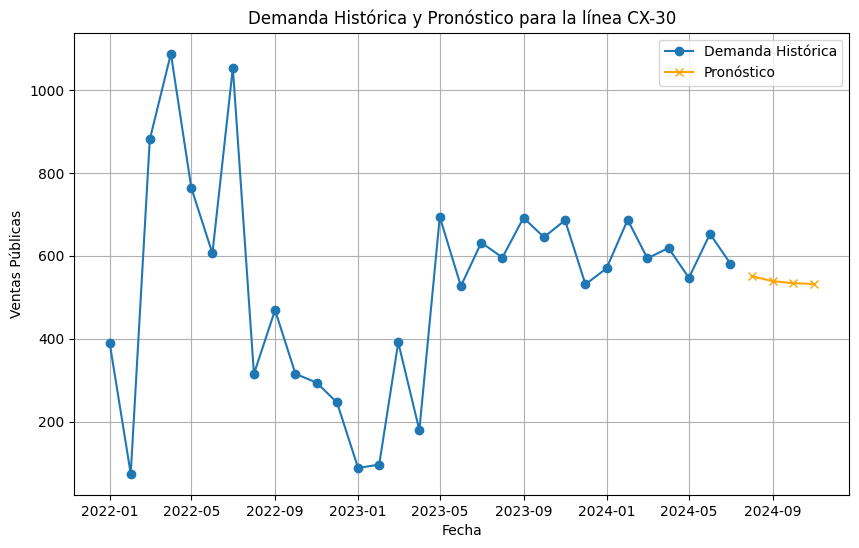

Predicciones para los próximos 4 periodos en la línea CX-30: 2024-08-01    551.0
2024-09-01    539.0
2024-10-01    534.0
2024-11-01    532.0
Freq: MS, dtype: float64
=== Pronóstico para la línea MX-5 ===


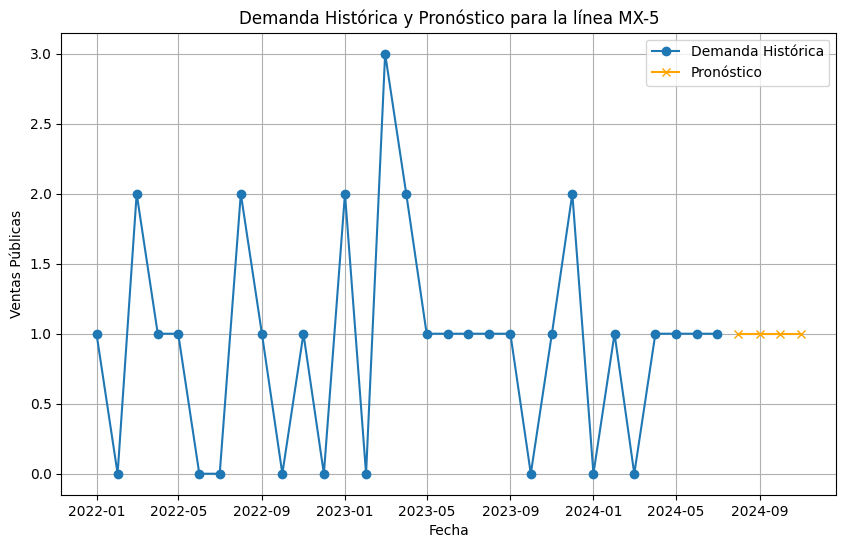

Predicciones para los próximos 4 periodos en la línea MX-5: 2024-08-01    1.0
2024-09-01    1.0
2024-10-01    1.0
2024-11-01    1.0
Freq: MS, dtype: float64
=== Pronóstico para la línea MAZDA3 SKYACTIV ===


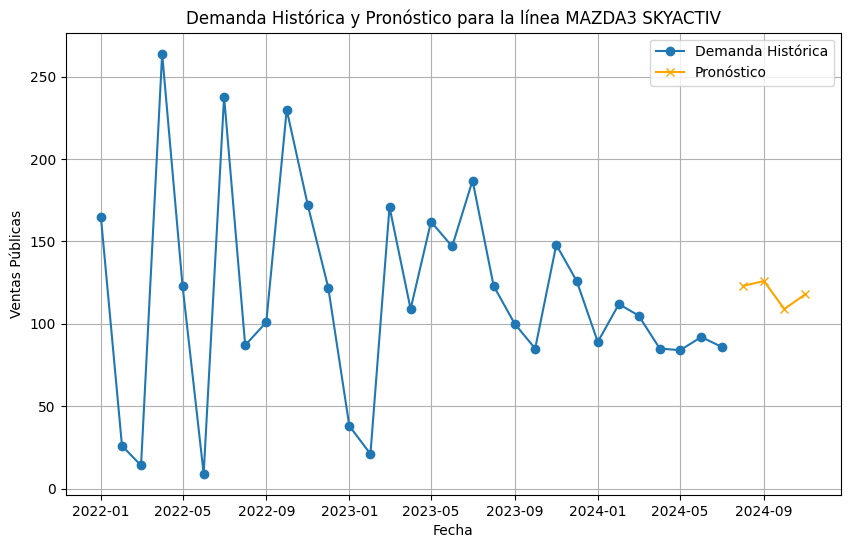

Predicciones para los próximos 4 periodos en la línea MAZDA3 SKYACTIV: 2024-08-01    123.0
2024-09-01    126.0
2024-10-01    109.0
2024-11-01    118.0
Freq: MS, dtype: float64
=== Pronóstico para la línea CX-5 ===


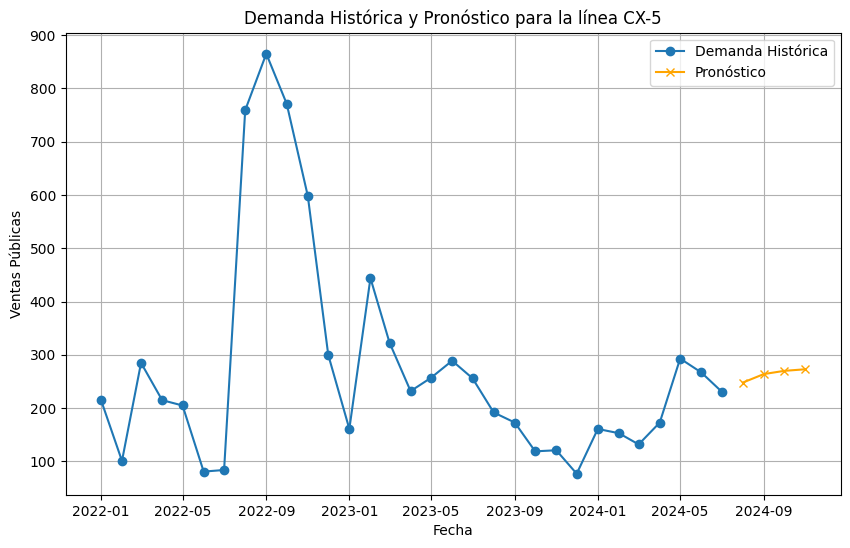

Predicciones para los próximos 4 periodos en la línea CX-5: 2024-08-01    248.0
2024-09-01    264.0
2024-10-01    270.0
2024-11-01    273.0
Freq: MS, dtype: float64
=== Pronóstico para la línea MAZDA2 HB SKYACTIV ===


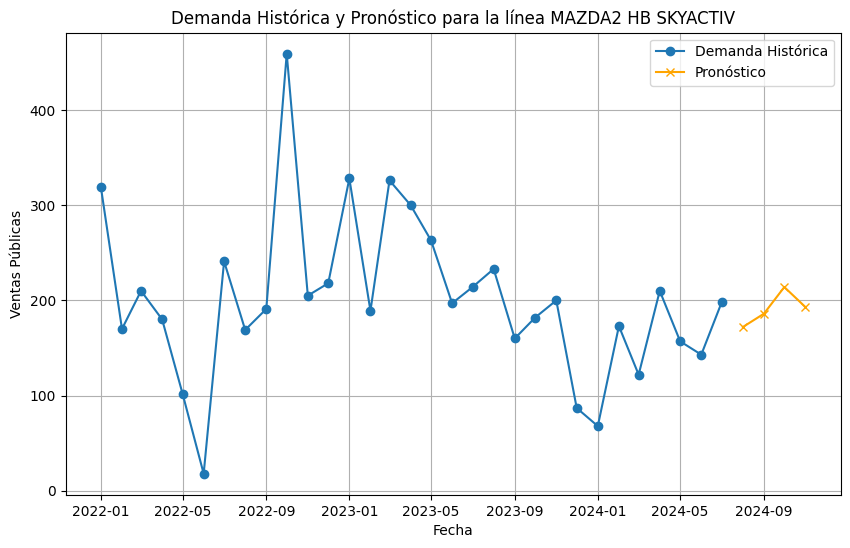

Predicciones para los próximos 4 periodos en la línea MAZDA2 HB SKYACTIV: 2024-08-01    172.0
2024-09-01    186.0
2024-10-01    214.0
2024-11-01    193.0
Freq: MS, dtype: float64
=== Pronóstico para la línea MAZDA2 SDN SKYACTIV ===


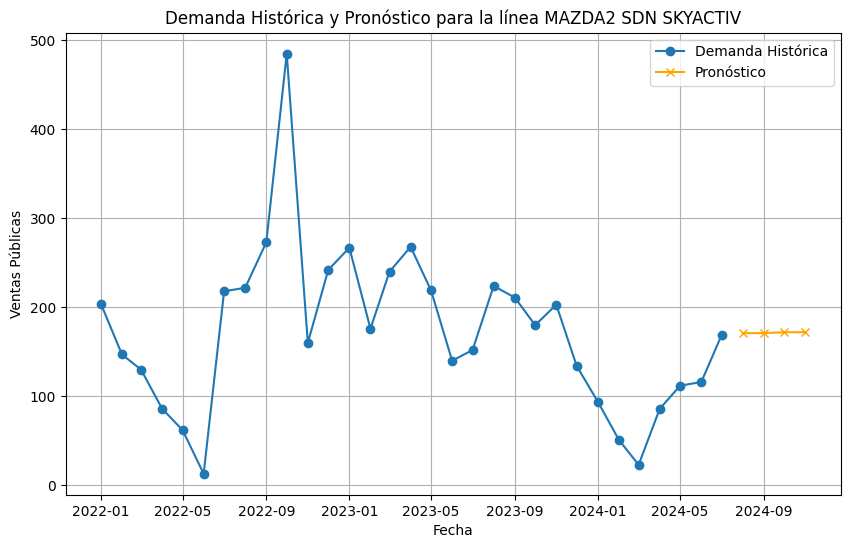

Predicciones para los próximos 4 periodos en la línea MAZDA2 SDN SKYACTIV: 2024-08-01    171.0
2024-09-01    171.0
2024-10-01    172.0
2024-11-01    172.0
Freq: MS, dtype: float64
=== Pronóstico para la línea CX-9 ===


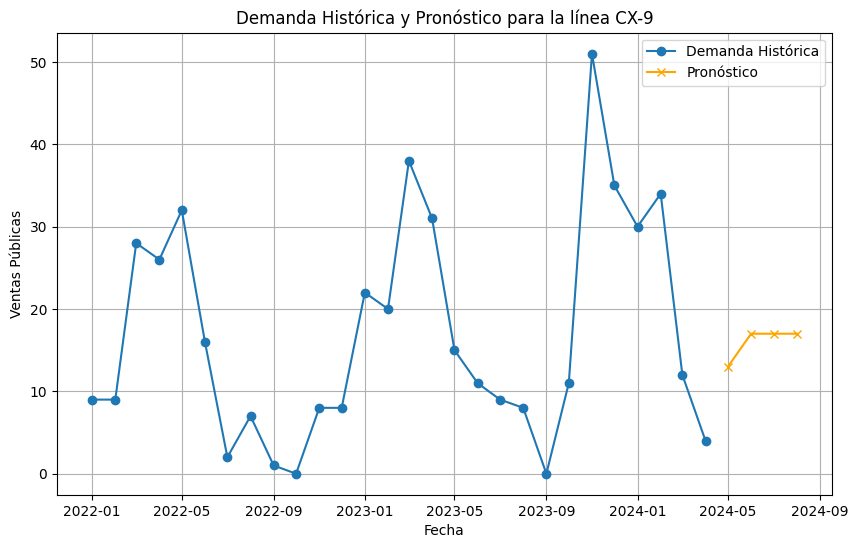

Predicciones para los próximos 4 periodos en la línea CX-9: 2024-05-01    13.0
2024-06-01    17.0
2024-07-01    17.0
2024-08-01    17.0
Freq: MS, dtype: float64
=== Pronóstico para la línea MX-30 ===


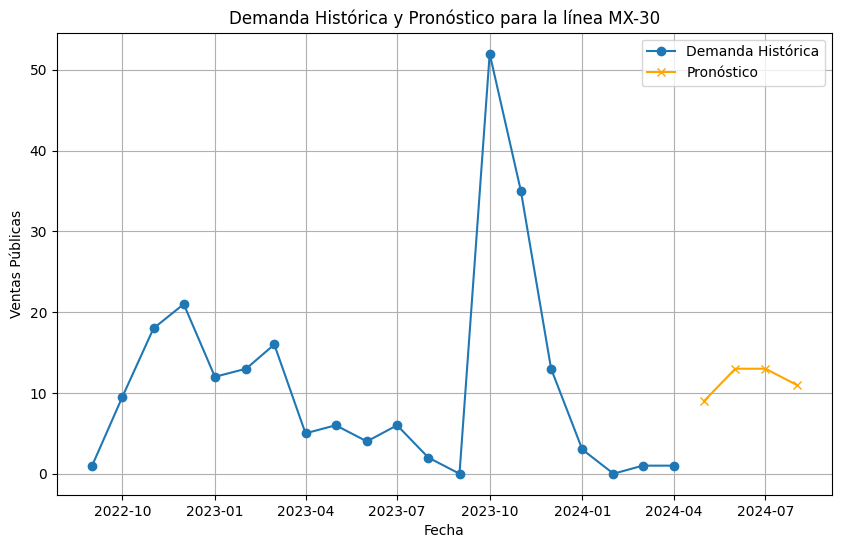

Predicciones para los próximos 4 periodos en la línea MX-30: 2024-05-01     9.0
2024-06-01    13.0
2024-07-01    13.0
2024-08-01    11.0
Freq: MS, dtype: float64
=== Pronóstico para la línea CX-50 ===


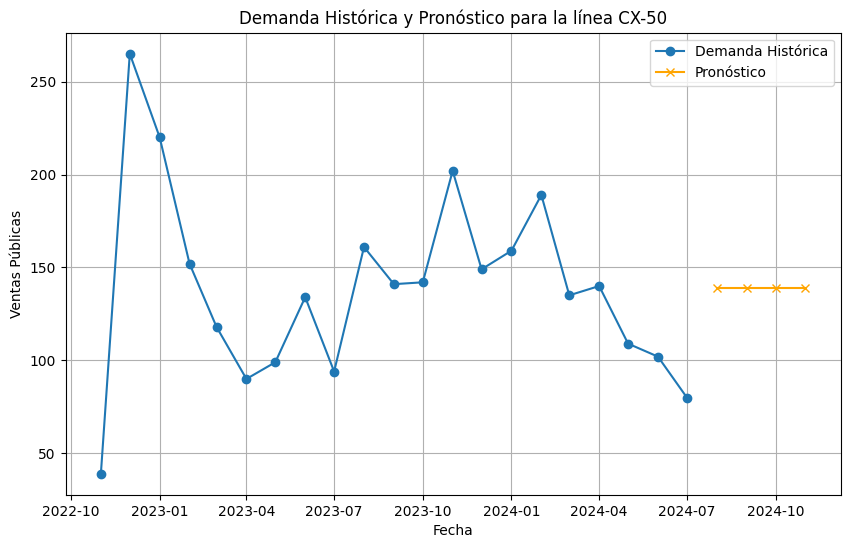

Predicciones para los próximos 4 periodos en la línea CX-50: 2024-08-01    139.0
2024-09-01    139.0
2024-10-01    139.0
2024-11-01    139.0
Freq: MS, dtype: float64
=== Pronóstico para la línea CX-60 ===


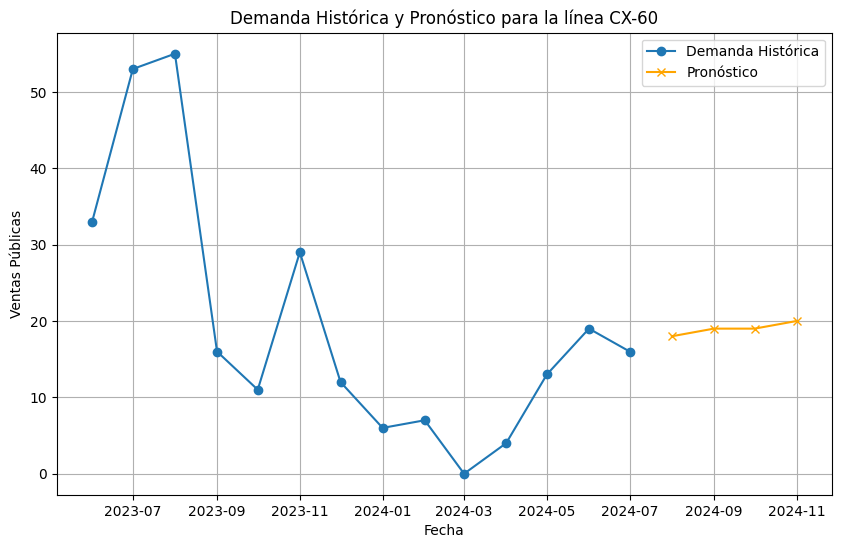

Predicciones para los próximos 4 periodos en la línea CX-60: 2024-08-01    18.0
2024-09-01    19.0
2024-10-01    19.0
2024-11-01    20.0
Freq: MS, dtype: float64
=== Pronóstico para la línea CX-90 ===


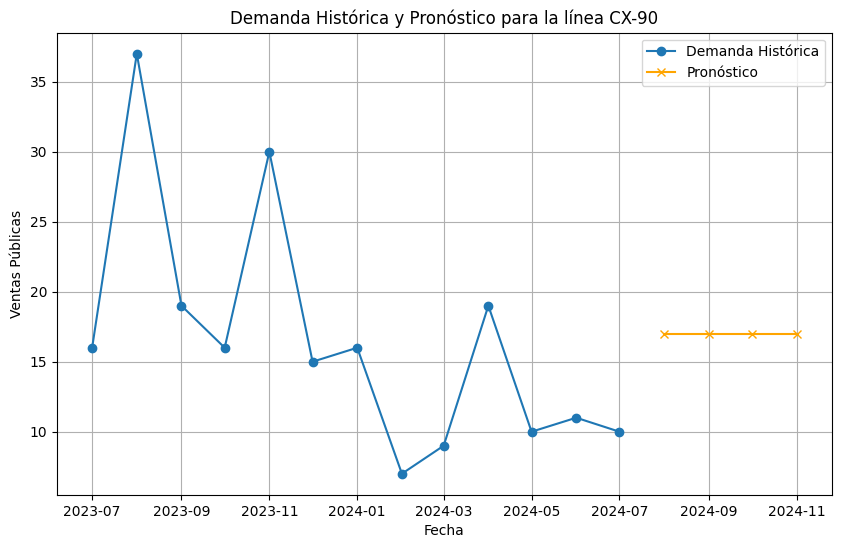

Predicciones para los próximos 4 periodos en la línea CX-90: 2024-08-01    17.0
2024-09-01    17.0
2024-10-01    17.0
2024-11-01    17.0
Freq: MS, dtype: float64


In [ ]:
# Inicializar una lista para almacenar el pronóstico de cada línea
pronosticos_por_linea = {}

# Columnas exógenas a utilizar
exog_cols = ['IPC', 'PIB', 'Tasa', 'Dolar', 'Crecimiento', 'Participacion']

# Agrupar los datos
df = Datos.groupby(['Periodo', 'Linea'], as_index=False).agg({'Vtas Pub.': 'sum'})

# Probar las líneas y realizar pronósticos
for linea in Lineas:
    print(f"=== Pronóstico para la línea {linea} ===")

    # Preparar los datos para ARIMAX
    X_train, y_train, X_pred = preparar_datos_arimax(df, MacroDatos, linea, rezago_ganador)

    # Si no se pudieron preparar los datos, saltar este ciclo
    if X_train is None or X_pred is None:
        continue

    # Entrenar el modelo ARIMAX y predecir para los próximos 4 periodos
    modelo, predicciones = entrenar_arimax(X_train, y_train, X_pred)

    if modelo is None or predicciones is None:
        continue

    # Crear un índice de fechas para los próximos 4 períodos
    future_dates = pd.date_range(start=y_train.index[-1] + pd.DateOffset(months=1), periods=4, freq='MS')

    # Almacenar el pronóstico en el diccionario para usar en la distribución de despacho
    pronosticos_por_linea[linea] = pd.Series(predicciones, index=future_dates)

    # Graficar la demanda histórica y el pronóstico
    plt.figure(figsize=(10, 6))
    plt.plot(y_train.index, y_train, label='Demanda Histórica', marker='o')
    plt.plot(future_dates, predicciones, label='Pronóstico', marker='x', color='orange')

    # Añadir títulos y leyendas
    plt.title(f'Demanda Histórica y Pronóstico para la línea {linea}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas Públicas')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Imprimir las predicciones redondeadas para los próximos 4 periodos
    print(f"Predicciones para los próximos 4 periodos en la línea {linea}: {np.round(predicciones)}")

# Ahora el diccionario 'pronosticos_por_linea' contiene el pronóstico de cada línea


## **Simulación para escoger la mejor estrategia de planeacion para cada linea**

### Predicciones de prueba solo para la simulación

In [ ]:
def preparar_datos_arimax(df, df_exog, linea, rezago=1):
    """
    Prepara los datos para el modelo ARIMAX, incluyendo las variables exógenas y las ventas públicas desfasadas.
    """
    # Limpiar los nombres de las columnas en ambos DataFrames
    df.columns = df.columns.str.strip()
    df_exog.columns = df_exog.columns.str.strip()

    # Filtrar los datos por línea
    df_filtrado = df[df['Linea'] == linea]

    # Agrupar los datos para evitar duplicados y sumar las ventas
    df_filtrado = df_filtrado.groupby('Periodo', as_index=False).agg({'Vtas Pub.': 'sum'})

    # Convertir 'Periodo' a formato datetime y configurar el índice
    df_filtrado['Periodo'] = pd.to_datetime(df_filtrado['Periodo'])
    df_filtrado.set_index('Periodo', inplace=True)

    # Alinear los datos con las variables exógenas
    df_exog_alineado = df_exog.loc[df_filtrado.index]

    # Desfazar las variables exógenas
    df_exog_alineado = df_exog_alineado.shift(rezago)

    # Rellenar valores NaN en las variables macroeconómicas
    df_exog_alineado.ffill(inplace=True)  # Usar el valor anterior
    df_exog_alineado.fillna(df_exog_alineado.mean(), inplace=True)  # Usar la media si aún hay NaN

    # Asegurar índice continuo en fechas mensuales
    full_index_train = pd.date_range(start=df_filtrado.index.min(), end=df_filtrado.index.max(), freq='MS')
    df_filtrado = df_filtrado.reindex(full_index_train).interpolate()
    df_exog_alineado = df_exog_alineado.reindex(full_index_train).interpolate()

    # Filtrar los datos hasta los últimos 4 periodos para predicción
    df_train = df_filtrado.iloc[:-4]
    df_exog_train = df_exog_alineado.iloc[:-4]

    # Últimos 4 periodos para predicción
    df_pred = df_filtrado.iloc[-4:]
    df_exog_pred = df_exog_alineado.iloc[-4:]

    # Verificar si hay suficientes datos
    if df_train.empty or df_exog_train.empty or df_pred.empty or df_exog_pred.empty:
        print(f"Datos insuficientes para la línea {linea}.")
        return None, None, None, None

    # Variables dependientes e independientes
    X_train = df_exog_train
    y_train = df_train['Vtas Pub.']
    X_pred = df_exog_pred
    y_real_ultimos = df_pred['Vtas Pub.']

    return X_train, y_train, X_pred, y_real_ultimos

def entrenar_arimax(X_train, y_train, X_pred):
    """
    Entrena un modelo ARIMAX (ARIMA con variables exógenas) y predice para los últimos 4 periodos.
    """
    # Verificar que haya suficientes datos
    if len(y_train) < 1:
        print("Datos insuficientes para entrenar el modelo ARIMAX.")
        return None, None

    try:
        # Entrenar el modelo ARIMAX utilizando auto_arima
        modelo_arimax = auto_arima(y_train, exogenous=X_train, seasonal=False, stepwise=True)

        # Realizar la predicción para los últimos 4 periodos
        predicciones = modelo_arimax.predict(n_periods=4, exogenous=X_pred)

        return modelo_arimax, np.round(predicciones)  # Redondear las predicciones a enteros

    except Exception as e:
        print(f"Error entrenando el modelo ARIMAX: {e}")
        return None, None

def obtener_errores_arimax(modelo_arimax, X_train, y_train):
    """
    Obtiene los errores (residuos) del modelo ARIMAX durante la etapa de entrenamiento.
    """
    try:
        # Obtener los valores ajustados del modelo ARIMAX
        valores_ajustados = modelo_arimax.predict_in_sample(exogenous=X_train)

        # Asegurar que los índices coinciden
        valores_ajustados = pd.Series(valores_ajustados, index=y_train.index)

        # Calcular los errores como la diferencia entre los valores reales y los ajustados
        errores = y_train - valores_ajustados

        return errores

    except Exception as e:
        print(f"Error al obtener los errores del modelo ARIMAX: {e}")
        return None

In [ ]:
# Uso de la función en el bucle principal
errores_normales = []  # Lista para guardar las líneas con errores normales
errores_no_normales = []  # Lista para guardar las líneas con errores no normales
arima = []  # Lista de los modelos usados para cada línea
prediccionesLineas = []  # Lista de todas las predicciones por línea hechas
valoresRealesLineas = []  # Lista de los valores reales por línea
erroresT = []  # Lista para almacenar todos los errores de cada línea
media_y_desviacion_por_linea = {}  # Diccionario para almacenar media y desviación de cada línea
Lineas = Datos['Linea'].unique()  # Asegúrate de usar el nombre correcto del DataFrame
ValoresX_Train = []  # Lista para almacenar los valores X_train por línea
ValoresY_Train = []  # Lista para almacenar los valores y_train por línea
modelo_arimax = []  # Lista de modelos Arimax

for linea in Lineas:
    print(f"=== Línea: {linea} ===")

    # Preparar los datos para ARIMAX
    X_train, y_train, X_pred, y_real_ultimos = preparar_datos_arimax(Datos, MacroDatos, linea, rezago=1)

    # Si no se pudieron preparar los datos, saltar este ciclo
    if X_train is None or X_pred is None or y_real_ultimos is None:
        continue
    ValoresX_Train.append(X_train)
    ValoresY_Train.append(y_train)
    # Entrenar el modelo ARIMAX y predecir para los últimos 4 periodos
    modelo, predicciones = entrenar_arimax(X_train, y_train, X_pred)

    if modelo is None or predicciones is None:
        continue

    # Obtener los errores de entrenamiento
    errores_entrenamiento = obtener_errores_arimax(modelo, X_train, y_train)
    erroresT.append(errores_entrenamiento)
    modelo_arimax.append(modelo)
    prediccionesLineas.append(predicciones)
    valoresRealesLineas.append(y_real_ultimos)
    arima.append(modelo)

    # Calcular la media y desviación estándar
    media_errores = np.mean(errores_entrenamiento)
    desviacion_errores = np.std(errores_entrenamiento)

    # Guardar media y desviación por línea
    media_y_desviacion_por_linea[linea] = (media_errores, desviacion_errores)

    # Imprimir media y desviación estándar de errores para cada línea
    print(f"Media de errores en la línea {linea}: {media_errores}")
    print(f"Desviación estándar de errores en la línea {linea}: {desviacion_errores}")

    # Seleccionar prueba de normalidad basada en el tamaño de muestra
    if len(errores_entrenamiento) < 30:
        # Usar prueba de Shapiro-Wilk para tamaños de muestra pequeños
        estadistico, p_valor = shapiro(errores_entrenamiento)
        prueba = "Shapiro-Wilk"
    else:
        # Usar prueba de Kolmogorov-Smirnov para tamaños grandes
        estadistico, p_valor = ks_1samp(errores_entrenamiento, cdf=norm.cdf, args=(media_errores, desviacion_errores))
        prueba = "Kolmogorov-Smirnov"

    if p_valor > 0.05:
        print(f"Los errores de entrenamiento en la línea {linea} tienen una distribución normal según {prueba} (p-valor = {p_valor:.4f}).")
        errores_normales.append(linea)
    else:
        print(f"Los errores de entrenamiento en la línea {linea} NO tienen una distribución normal según {prueba} (p-valor = {p_valor:.4f}).")
        errores_no_normales.append(linea)

# Mostrar un resumen final de las líneas con errores normales y no normales
print("\n--- Resumen de los resultados ---")
if errores_normales:
    print(f"Las siguientes líneas tienen errores de entrenamiento con distribución normal: {', '.join(errores_normales)}")
else:
    print("Ninguna de las líneas tiene errores de entrenamiento con distribución normal.")

if errores_no_normales:
    print(f"Las siguientes líneas tienen errores de entrenamiento que NO siguen una distribución normal: {', '.join(errores_no_normales)}")
else:
    print("Todas las líneas tienen errores de entrenamiento con distribución normal.")

# Imprimir media y desviación por línea
print("\n--- Media y Desviación Estándar por Línea ---")
for linea, (media, desviacion) in media_y_desviacion_por_linea.items():
    print(f"Línea {linea}: Media = {media:.4f}, Desviación Estándar = {desviacion:.4f}")


=== Línea: CX-30 ===
Media de errores en la línea CX-30: 1.6368841488837675
Desviación estándar de errores en la línea CX-30: 242.41141590681013
Los errores de entrenamiento en la línea CX-30 tienen una distribución normal según Shapiro-Wilk (p-valor = 0.3017).
=== Línea: MX-5 ===
Media de errores en la línea MX-5: 2.3934693856494014e-09
Desviación estándar de errores en la línea MX-5: 0.8131295703740796
Los errores de entrenamiento en la línea MX-5 NO tienen una distribución normal según Shapiro-Wilk (p-valor = 0.0008).
=== Línea: MAZDA3 SKYACTIV ===
Media de errores en la línea MAZDA3 SKYACTIV: -0.3623415455584059
Desviación estándar de errores en la línea MAZDA3 SKYACTIV: 59.25729618492823
Los errores de entrenamiento en la línea MAZDA3 SKYACTIV tienen una distribución normal según Shapiro-Wilk (p-valor = 0.6222).
=== Línea: CX-5 ===
Media de errores en la línea CX-5: -1.1160946722448115
Desviación estándar de errores en la línea CX-5: 150.93011477997285
Los errores de entrenamiento

In [ ]:
ServicioiRED=[]
ServicioiCENTRO=[]
diasInventarioRED=[]
diasInventarioCENTRO=[]
prediccion= prediccionesLineas[0]
# Supongamos que ya tienes los periodos en el pronóstico
periodos = prediccion.index.strftime('%Y-%m') if isinstance(prediccion, pd.DataFrame) else list(prediccion.keys())

# Convertir el primer periodo a datetime para manipulación de fechas
primer_periodo = pd.to_datetime(periodos[0], format='%Y-%m')

# Generar los cuatro periodos anteriores
periodos_anteriores = pd.date_range(end=primer_periodo - pd.DateOffset(months=1), periods=4, freq='MS').strftime('%Y-%m')

# Concatenar los periodos anteriores con los periodos originales
periodos = list(periodos_anteriores) + list(periodos)

mesAnterior = periodos_anteriores[3]

# Convertir todos los periodos a strings en formato '%Y-%m'
periodos = [pd.to_datetime(period).strftime('%Y-%m') for period in periodos]

print(periodos)

print(mesAnterior)

['2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07']
2024-03


### funciones para la simulación

In [ ]:
def calcular_despacho_y_indicadoresS5(prediccion, valoresRealesLineas, Datos, linea, periodos, porcentajeFabricas=[0.2, 0.2, 0.6]):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos.
    Retorna un DataFrame y los promedios de los indicadores.

    Args:
        prediccion: Lista de predicciones para los períodos.
        valoresRealesLineas: Lista de valores reales de la línea.
        Datos: DataFrame con datos de ventas y modelos.
        linea: Línea actual para el análisis.
        periodos: Lista de períodos.
        porcentajeFabricas: Porcentajes para las fábricas.

    Returns:
        dict: Contiene el DataFrame del centro, un DataFrame de resultados de la red,
              y los promedios de los indicadores del centro y la red.
    """

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN, RR = [[0] * len(periodos) for _ in range(6)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF = [[0] * len(periodos) for _ in range(3)]

    # Inicializar Despacho_Real y Demanda_Ciudad con ceros
    Despacho_Real = [0] * len(periodos)
    Demanda_Ciudad = [0] * len(periodos)

    # Inicialización de indicadores como promedios
    indicadores_centro = {"dias_inv": None, "servicio_tipo_ii": None}
    indicadores_red = {"dias_inv": None, "servicio_tipo_ii": None}

    # Stock de seguridad del 5% del pronóstico para los últimos 4 períodos
    SS[-4:] = np.ceil([p * 0.05 for p in prediccion])
    RB[-4:] = prediccion
    RR[-4:] = valoresRealesLineas

    # Cálculo del inventario por períodos
    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    estructura = {
        "Periodo": periodos,
        "RR": RR,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Demanda Concesionarios": Demanda_Ciudad,
        "Despacho Real": Despacho_Real,
        "Inventario Neto": Inv,
        "Inventario Sobrante": InvS,
        "Inventario Faltante": InvF
    }

    df = pd.DataFrame(estructura)
    df.set_index("Periodo", inplace=True)

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    dias_inv_por_ciudad = []
    servicio_tipo_ii_por_ciudad = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            demanda_base = df["RR"].tail(4).values
            pronostico_base = df["RN"].tail(4).values
            demanda = np.ceil(demanda_base * (porcentaje_modelo / 100))
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))

            inventarios = np.maximum(pronostico_modelo - demanda, 0)
            faltantes = np.maximum(demanda - pronostico_modelo, 0)

            filas_ciudad_modelo.append({
                "Ciudad": ciudad,
                "Modelo": modelo,
                "Demanda": demanda.tolist(),
                "Pronostico": pronostico_modelo.tolist(),
                "INV": inventarios.tolist(),
                "Faltantes": faltantes.tolist()
            })

            # Sumar el pronóstico y la demanda de las ciudades
            for j in range(len(pronostico_modelo)):
                Despacho_Real[-4 + j] += pronostico_modelo[j]
                Demanda_Ciudad[-4 + j] += demanda[j]

            # Calcular indicadores por ciudad y modelo
            promedio_pronostico = pronostico_modelo.mean()
            promedio_demanda = demanda.mean()
            dias_inventario = max(0, inventarios.sum() / promedio_pronostico * 30 if promedio_pronostico > 0 else 0)
            servicio_tipo_ii = max(0, 1 - (faltantes.sum() / promedio_demanda)) if promedio_demanda > 0 else 1

            dias_inv_por_ciudad.append(dias_inventario)
            servicio_tipo_ii_por_ciudad.append(servicio_tipo_ii)

    # Calcular los promedios para los indicadores de red
    indicadores_red["dias_inv"] = np.mean(dias_inv_por_ciudad)
    indicadores_red["servicio_tipo_ii"] = np.mean(servicio_tipo_ii_por_ciudad)

    # Actualizar últimos 4 períodos
    for i in range(4):
        df.loc[df.index[-4 + i], "Despacho Real"] = Despacho_Real[-4 + i]
        df.loc[df.index[-4 + i], "Demanda Concesionarios"] = Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Neto"] = Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Sobrante"] = max(0, Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i])
        df.loc[df.index[-4 + i], "Inventario Faltante"] = max(0, Demanda_Ciudad[-4 + i] - Despacho_Real[-4 + i])

    # Calcular indicadores del centro de distribución
    promedio_despacho_real = df["Despacho Real"].iloc[-4:].mean()
    promedio_demanda = df["Demanda Concesionarios"].iloc[-4:].mean()
    promedio_inv = df["Inventario Neto"].iloc[-4:].mean()
    promedio_inv_faltante = df["Inventario Faltante"].iloc[-4:].mean()

    dias_inv_centro_mean = max(0, promedio_inv / promedio_despacho_real * 30) if promedio_despacho_real > 0 else 0
    servicio_centro_mean = max(0, 1 - (promedio_inv_faltante / promedio_demanda)) if promedio_demanda > 0 else 1

    indicadores_centro["dias_inv"] = dias_inv_centro_mean
    indicadores_centro["servicio_tipo_ii"] = servicio_centro_mean

    #trasponer el df
    df=df.T
    # Convertir filas de resultados de la red a DataFrame
    df_resultado_red = pd.DataFrame(filas_ciudad_modelo)

    return {
        "df_centro": df,  # DataFrame transpuesto del centro
        "df_resultado_red": df_resultado_red,  # DataFrame de la red
        "indicadores_centro": indicadores_centro,  # Promedios del centro
        "indicadores_red": indicadores_red  # Promedios de la red
    }


In [ ]:
def calcular_despacho_y_indicadoresS10(prediccion, valoresRealesLineas, Datos, linea, periodos, porcentajeFabricas=[0.2, 0.2, 0.6]):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos.
    Retorna un DataFrame y los promedios de los indicadores.

    Args:
        prediccion: Lista de predicciones para los períodos.
        valoresRealesLineas: Lista de valores reales de la línea.
        Datos: DataFrame con datos de ventas y modelos.
        linea: Línea actual para el análisis.
        periodos: Lista de períodos.
        porcentajeFabricas: Porcentajes para las fábricas.

    Returns:
        dict: Contiene el DataFrame del centro, un DataFrame de resultados de la red,
              y los promedios de los indicadores del centro y la red.
    """

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN, RR = [[0] * len(periodos) for _ in range(6)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF = [[0] * len(periodos) for _ in range(3)]

    # Inicializar Despacho_Real y Demanda_Ciudad con ceros
    Despacho_Real = [0] * len(periodos)
    Demanda_Ciudad = [0] * len(periodos)

    # Inicialización de indicadores como promedios
    indicadores_centro = {"dias_inv": None, "servicio_tipo_ii": None}
    indicadores_red = {"dias_inv": None, "servicio_tipo_ii": None}

    # Stock de seguridad del 10% del pronóstico para los últimos 4 períodos
    SS[-4:] = np.ceil([p * 0.10 for p in prediccion])
    RB[-4:] = prediccion
    RR[-4:] = valoresRealesLineas

    # Cálculo del inventario por períodos
    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    estructura = {
        "Periodo": periodos,
        "RR": RR,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Demanda Concesionarios": Demanda_Ciudad,
        "Despacho Real": Despacho_Real,
        "Inventario Neto": Inv,
        "Inventario Sobrante": InvS,
        "Inventario Faltante": InvF
    }

    df = pd.DataFrame(estructura)
    df.set_index("Periodo", inplace=True)

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    dias_inv_por_ciudad = []
    servicio_tipo_ii_por_ciudad = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            demanda_base = df["RR"].tail(4).values
            pronostico_base = df["RN"].tail(4).values
            demanda = np.ceil(demanda_base * (porcentaje_modelo / 100))
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))

            inventarios = np.maximum(pronostico_modelo - demanda, 0)
            faltantes = np.maximum(demanda - pronostico_modelo, 0)

            filas_ciudad_modelo.append({
                "Ciudad": ciudad,
                "Modelo": modelo,
                "Demanda": demanda.tolist(),
                "Pronostico": pronostico_modelo.tolist(),
                "INV": inventarios.tolist(),
                "Faltantes": faltantes.tolist()
            })

            # Sumar el pronóstico y la demanda de las ciudades
            for j in range(len(pronostico_modelo)):
                Despacho_Real[-4 + j] += pronostico_modelo[j]
                Demanda_Ciudad[-4 + j] += demanda[j]

            # Calcular indicadores por ciudad y modelo
            promedio_pronostico = pronostico_modelo.mean()
            promedio_demanda = demanda.mean()
            dias_inventario = max(0, inventarios.sum() / promedio_pronostico * 30 if promedio_pronostico > 0 else 0)
            servicio_tipo_ii = max(0, 1 - (faltantes.sum() / promedio_demanda)) if promedio_demanda > 0 else 1

            dias_inv_por_ciudad.append(dias_inventario)
            servicio_tipo_ii_por_ciudad.append(servicio_tipo_ii)

    # Calcular los promedios para los indicadores de red
    indicadores_red["dias_inv"] = np.mean(dias_inv_por_ciudad)
    indicadores_red["servicio_tipo_ii"] = np.mean(servicio_tipo_ii_por_ciudad)

    # Actualizar últimos 4 períodos
    for i in range(4):
        df.loc[df.index[-4 + i], "Despacho Real"] = Despacho_Real[-4 + i]
        df.loc[df.index[-4 + i], "Demanda Concesionarios"] = Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Neto"] = Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Sobrante"] = max(0, Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i])
        df.loc[df.index[-4 + i], "Inventario Faltante"] = max(0, Demanda_Ciudad[-4 + i] - Despacho_Real[-4 + i])

    # Calcular indicadores del centro de distribución
    promedio_despacho_real = df["Despacho Real"].iloc[-4:].mean()
    promedio_demanda = df["Demanda Concesionarios"].iloc[-4:].mean()
    promedio_inv = df["Inventario Neto"].iloc[-4:].mean()
    promedio_inv_faltante = df["Inventario Faltante"].iloc[-4:].mean()

    dias_inv_centro_mean = max(0, promedio_inv / promedio_despacho_real * 30) if promedio_despacho_real > 0 else 0
    servicio_centro_mean = max(0, 1 - (promedio_inv_faltante / promedio_demanda)) if promedio_demanda > 0 else 1

    indicadores_centro["dias_inv"] = dias_inv_centro_mean
    indicadores_centro["servicio_tipo_ii"] = servicio_centro_mean

    #trasponer el df
    df=df.T
    # Convertir filas de resultados de la red a DataFrame
    df_resultado_red = pd.DataFrame(filas_ciudad_modelo)

    return {
        "df_centro": df,  # DataFrame transpuesto del centro
        "df_resultado_red": df_resultado_red,  # DataFrame de la red
        "indicadores_centro": indicadores_centro,  # Promedios del centro
        "indicadores_red": indicadores_red  # Promedios de la red
    }


In [ ]:
def calcular_despacho_y_indicadoresS15(prediccion, valoresRealesLineas, Datos, linea, periodos, porcentajeFabricas=[0.2, 0.2, 0.6]):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos.
    Retorna un DataFrame y los promedios de los indicadores.

    Args:
        prediccion: Lista de predicciones para los períodos.
        valoresRealesLineas: Lista de valores reales de la línea.
        Datos: DataFrame con datos de ventas y modelos.
        linea: Línea actual para el análisis.
        periodos: Lista de períodos.
        porcentajeFabricas: Porcentajes para las fábricas.

    Returns:
        dict: Contiene el DataFrame del centro, un DataFrame de resultados de la red,
              y los promedios de los indicadores del centro y la red.
    """

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN, RR = [[0] * len(periodos) for _ in range(6)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF = [[0] * len(periodos) for _ in range(3)]

    # Inicializar Despacho_Real y Demanda_Ciudad con ceros
    Despacho_Real = [0] * len(periodos)
    Demanda_Ciudad = [0] * len(periodos)

    # Inicialización de indicadores como promedios
    indicadores_centro = {"dias_inv": None, "servicio_tipo_ii": None}
    indicadores_red = {"dias_inv": None, "servicio_tipo_ii": None}

    # Stock de seguridad del 15% del pronóstico para los últimos 4 períodos
    SS[-4:] = np.ceil([p * 0.15 for p in prediccion])
    RB[-4:] = prediccion
    RR[-4:] = valoresRealesLineas

    # Cálculo del inventario por períodos
    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    estructura = {
        "Periodo": periodos,
        "RR": RR,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Demanda Concesionarios": Demanda_Ciudad,
        "Despacho Real": Despacho_Real,
        "Inventario Neto": Inv,
        "Inventario Sobrante": InvS,
        "Inventario Faltante": InvF
    }

    df = pd.DataFrame(estructura)
    df.set_index("Periodo", inplace=True)

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    dias_inv_por_ciudad = []
    servicio_tipo_ii_por_ciudad = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            demanda_base = df["RR"].tail(4).values
            pronostico_base = df["RN"].tail(4).values
            demanda = np.ceil(demanda_base * (porcentaje_modelo / 100))
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))

            inventarios = np.maximum(pronostico_modelo - demanda, 0)
            faltantes = np.maximum(demanda - pronostico_modelo, 0)

            filas_ciudad_modelo.append({
                "Ciudad": ciudad,
                "Modelo": modelo,
                "Demanda": demanda.tolist(),
                "Pronostico": pronostico_modelo.tolist(),
                "INV": inventarios.tolist(),
                "Faltantes": faltantes.tolist()
            })

            # Sumar el pronóstico y la demanda de las ciudades
            for j in range(len(pronostico_modelo)):
                Despacho_Real[-4 + j] += pronostico_modelo[j]
                Demanda_Ciudad[-4 + j] += demanda[j]

            # Calcular indicadores por ciudad y modelo
            promedio_pronostico = pronostico_modelo.mean()
            promedio_demanda = demanda.mean()
            dias_inventario = max(0, inventarios.sum() / promedio_pronostico * 30 if promedio_pronostico > 0 else 0)
            servicio_tipo_ii = max(0, 1 - (faltantes.sum() / promedio_demanda)) if promedio_demanda > 0 else 1

            dias_inv_por_ciudad.append(dias_inventario)
            servicio_tipo_ii_por_ciudad.append(servicio_tipo_ii)

    # Calcular los promedios para los indicadores de red
    indicadores_red["dias_inv"] = np.mean(dias_inv_por_ciudad)
    indicadores_red["servicio_tipo_ii"] = np.mean(servicio_tipo_ii_por_ciudad)

    # Actualizar últimos 4 períodos
    for i in range(4):
        df.loc[df.index[-4 + i], "Despacho Real"] = Despacho_Real[-4 + i]
        df.loc[df.index[-4 + i], "Demanda Concesionarios"] = Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Neto"] = Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Sobrante"] = max(0, Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i])
        df.loc[df.index[-4 + i], "Inventario Faltante"] = max(0, Demanda_Ciudad[-4 + i] - Despacho_Real[-4 + i])

    # Calcular indicadores del centro de distribución
    promedio_despacho_real = df["Despacho Real"].iloc[-4:].mean()
    promedio_demanda = df["Demanda Concesionarios"].iloc[-4:].mean()
    promedio_inv = df["Inventario Neto"].iloc[-4:].mean()
    promedio_inv_faltante = df["Inventario Faltante"].iloc[-4:].mean()

    dias_inv_centro_mean = max(0, promedio_inv / promedio_despacho_real * 30) if promedio_despacho_real > 0 else 0
    servicio_centro_mean = max(0, 1 - (promedio_inv_faltante / promedio_demanda)) if promedio_demanda > 0 else 1

    indicadores_centro["dias_inv"] = dias_inv_centro_mean
    indicadores_centro["servicio_tipo_ii"] = servicio_centro_mean

    #trasponer el df
    df=df.T
    # Convertir filas de resultados de la red a DataFrame
    df_resultado_red = pd.DataFrame(filas_ciudad_modelo)

    return {
        "df_centro": df,  # DataFrame transpuesto del centro
        "df_resultado_red": df_resultado_red,  # DataFrame de la red
        "indicadores_centro": indicadores_centro,  # Promedios del centro
        "indicadores_red": indicadores_red  # Promedios de la red
    }


In [ ]:
def calcular_despacho_y_indicadores60Total(prediccion, valoresRealesLineas, Datos, linea, periodos, porcentajeFabricas=[0.2, 0.2, 0.6]):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos.
    Retorna un DataFrame y los promedios de los indicadores.

    Args:
        prediccion: Lista de predicciones para los períodos.
        valoresRealesLineas: Lista de valores reales de la línea.
        Datos: DataFrame con datos de ventas y modelos.
        linea: Línea actual para el análisis.
        periodos: Lista de períodos.
        porcentajeFabricas: Porcentajes para las fábricas.

    Returns:
        dict: Contiene el DataFrame del centro, un DataFrame de resultados de la red,
              y los promedios de los indicadores del centro y la red.
    """
    total_ventas_publicas = Datos[(Datos['Periodo'].dt.strftime('%Y-%m') == mesAnterior) & (Datos['Linea'] == linea)]['Vtas Pub.'].sum()

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN, RR = [[0] * len(periodos) for _ in range(6)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF = [[0] * len(periodos) for _ in range(3)]

    # Inicializar Despacho_Real y Demanda_Ciudad con ceros
    Despacho_Real = [0] * len(periodos)
    Demanda_Ciudad = [0] * len(periodos)

    # Inicialización de indicadores como promedios
    indicadores_centro = {"dias_inv": None, "servicio_tipo_ii": None}
    indicadores_red = {"dias_inv": None, "servicio_tipo_ii": None}

    # Stock de seguridad del 60% de las ventas publicas del pronóstico para los últimos 4 períodos
    SS[-4:] = [np.ceil(total_ventas_publicas * 0.6)] * 4
    RB[-4:] = prediccion
    RR[-4:] = valoresRealesLineas

    # Cálculo del inventario por períodos
    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    estructura = {
        "Periodo": periodos,
        "RR": RR,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Demanda Concesionarios": Demanda_Ciudad,
        "Despacho Real": Despacho_Real,
        "Inventario Neto": Inv,
        "Inventario Sobrante": InvS,
        "Inventario Faltante": InvF
    }

    df = pd.DataFrame(estructura)
    df.set_index("Periodo", inplace=True)

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    dias_inv_por_ciudad = []
    servicio_tipo_ii_por_ciudad = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            demanda_base = df["RR"].tail(4).values
            pronostico_base = df["RN"].tail(4).values
            demanda = np.ceil(demanda_base * (porcentaje_modelo / 100))
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))

            inventarios = np.maximum(pronostico_modelo - demanda, 0)
            faltantes = np.maximum(demanda - pronostico_modelo, 0)

            filas_ciudad_modelo.append({
                "Ciudad": ciudad,
                "Modelo": modelo,
                "Demanda": demanda.tolist(),
                "Pronostico": pronostico_modelo.tolist(),
                "INV": inventarios.tolist(),
                "Faltantes": faltantes.tolist()
            })

            # Sumar el pronóstico y la demanda de las ciudades
            for j in range(len(pronostico_modelo)):
                Despacho_Real[-4 + j] += pronostico_modelo[j]
                Demanda_Ciudad[-4 + j] += demanda[j]

            # Calcular indicadores por ciudad y modelo
            promedio_pronostico = pronostico_modelo.mean()
            promedio_demanda = demanda.mean()
            dias_inventario = max(0, inventarios.sum() / promedio_pronostico * 30 if promedio_pronostico > 0 else 0)
            servicio_tipo_ii = max(0, 1 - (faltantes.sum() / promedio_demanda)) if promedio_demanda > 0 else 1

            dias_inv_por_ciudad.append(dias_inventario)
            servicio_tipo_ii_por_ciudad.append(servicio_tipo_ii)

    # Calcular los promedios para los indicadores de red
    indicadores_red["dias_inv"] = np.mean(dias_inv_por_ciudad)
    indicadores_red["servicio_tipo_ii"] = np.mean(servicio_tipo_ii_por_ciudad)

    # Actualizar últimos 4 períodos
    for i in range(4):
        df.loc[df.index[-4 + i], "Despacho Real"] = Despacho_Real[-4 + i]
        df.loc[df.index[-4 + i], "Demanda Concesionarios"] = Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Neto"] = Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Sobrante"] = max(0, Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i])
        df.loc[df.index[-4 + i], "Inventario Faltante"] = max(0, Demanda_Ciudad[-4 + i] - Despacho_Real[-4 + i])

    # Calcular indicadores del centro de distribución
    promedio_despacho_real = df["Despacho Real"].iloc[-4:].mean()
    promedio_demanda = df["Demanda Concesionarios"].iloc[-4:].mean()
    promedio_inv = df["Inventario Neto"].iloc[-4:].mean()
    promedio_inv_faltante = df["Inventario Faltante"].iloc[-4:].mean()

    dias_inv_centro_mean = max(0, promedio_inv / promedio_despacho_real * 30) if promedio_despacho_real > 0 else 0
    servicio_centro_mean = max(0, 1 - (promedio_inv_faltante / promedio_demanda)) if promedio_demanda > 0 else 1

    indicadores_centro["dias_inv"] = dias_inv_centro_mean
    indicadores_centro["servicio_tipo_ii"] = servicio_centro_mean

    #trasponer el df
    df=df.T
    # Convertir filas de resultados de la red a DataFrame
    df_resultado_red = pd.DataFrame(filas_ciudad_modelo)

    return {
        "df_centro": df,  # DataFrame transpuesto del centro
        "df_resultado_red": df_resultado_red,  # DataFrame de la red
        "indicadores_centro": indicadores_centro,  # Promedios del centro
        "indicadores_red": indicadores_red  # Promedios de la red
    }


In [ ]:
def calcular_despacho_y_indicadores60Total2periodos(prediccion, valoresRealesLineas, Datos, linea, periodos, porcentajeFabricas=[0.2, 0.2, 0.6]):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos.
    Retorna un DataFrame y los promedios de los indicadores.

    Args:
        prediccion: Lista de predicciones para los períodos.
        valoresRealesLineas: Lista de valores reales de la línea.
        Datos: DataFrame con datos de ventas y modelos.
        linea: Línea actual para el análisis.
        periodos: Lista de períodos.
        porcentajeFabricas: Porcentajes para las fábricas.

    Returns:
        dict: Contiene el DataFrame del centro, un DataFrame de resultados de la red,
              y los promedios de los indicadores del centro y la red.
    """
    total_ventas_publicas = Datos[(Datos['Periodo'].dt.strftime('%Y-%m') == mesAnterior) & (Datos['Linea'] == linea)]['Vtas Pub.'].sum()

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN, RR = [[0] * len(periodos) for _ in range(6)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF = [[0] * len(periodos) for _ in range(3)]

    # Inicializar Despacho_Real y Demanda_Ciudad con ceros
    Despacho_Real = [0] * len(periodos)
    Demanda_Ciudad = [0] * len(periodos)

    # Inicialización de indicadores como promedios
    indicadores_centro = {"dias_inv": None, "servicio_tipo_ii": None}
    indicadores_red = {"dias_inv": None, "servicio_tipo_ii": None}

    # Stock de seguridad del 60% de las ventas publicas del pronóstico para los últimos 2 periodos
    SS[-2] = np.ceil(total_ventas_publicas * 0.2)
    SS[-4] = np.ceil(total_ventas_publicas * 0.2)
    RB[-4:] = prediccion
    RR[-4:] = valoresRealesLineas

    # Cálculo del inventario por períodos
    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    estructura = {
        "Periodo": periodos,
        "RR": RR,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Demanda Concesionarios": Demanda_Ciudad,
        "Despacho Real": Despacho_Real,
        "Inventario Neto": Inv,
        "Inventario Sobrante": InvS,
        "Inventario Faltante": InvF
    }

    df = pd.DataFrame(estructura)
    df.set_index("Periodo", inplace=True)

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    dias_inv_por_ciudad = []
    servicio_tipo_ii_por_ciudad = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            demanda_base = df["RR"].tail(4).values
            pronostico_base = df["RN"].tail(4).values
            demanda = np.ceil(demanda_base * (porcentaje_modelo / 100))
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))

            inventarios = np.maximum(pronostico_modelo - demanda, 0)
            faltantes = np.maximum(demanda - pronostico_modelo, 0)

            filas_ciudad_modelo.append({
                "Ciudad": ciudad,
                "Modelo": modelo,
                "Demanda": demanda.tolist(),
                "Pronostico": pronostico_modelo.tolist(),
                "INV": inventarios.tolist(),
                "Faltantes": faltantes.tolist()
            })

            # Sumar el pronóstico y la demanda de las ciudades
            for j in range(len(pronostico_modelo)):
                Despacho_Real[-4 + j] += pronostico_modelo[j]
                Demanda_Ciudad[-4 + j] += demanda[j]

            # Calcular indicadores por ciudad y modelo
            promedio_pronostico = pronostico_modelo.mean()
            promedio_demanda = demanda.mean()
            dias_inventario = max(0, inventarios.sum() / promedio_pronostico * 30 if promedio_pronostico > 0 else 0)
            servicio_tipo_ii = max(0, 1 - (faltantes.sum() / promedio_demanda)) if promedio_demanda > 0 else 1

            dias_inv_por_ciudad.append(dias_inventario)
            servicio_tipo_ii_por_ciudad.append(servicio_tipo_ii)

    # Calcular los promedios para los indicadores de red
    indicadores_red["dias_inv"] = np.mean(dias_inv_por_ciudad)
    indicadores_red["servicio_tipo_ii"] = np.mean(servicio_tipo_ii_por_ciudad)

    # Actualizar últimos 4 períodos
    for i in range(4):
        df.loc[df.index[-4 + i], "Despacho Real"] = Despacho_Real[-4 + i]
        df.loc[df.index[-4 + i], "Demanda Concesionarios"] = Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Neto"] = Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i]
        df.loc[df.index[-4 + i], "Inventario Sobrante"] = max(0, Despacho_Real[-4 + i] - Demanda_Ciudad[-4 + i])
        df.loc[df.index[-4 + i], "Inventario Faltante"] = max(0, Demanda_Ciudad[-4 + i] - Despacho_Real[-4 + i])

    # Calcular indicadores del centro de distribución
    promedio_despacho_real = df["Despacho Real"].iloc[-4:].mean()
    promedio_demanda = df["Demanda Concesionarios"].iloc[-4:].mean()
    promedio_inv = df["Inventario Neto"].iloc[-4:].mean()
    promedio_inv_faltante = df["Inventario Faltante"].iloc[-4:].mean()

    dias_inv_centro_mean = max(0, promedio_inv / promedio_despacho_real * 30) if promedio_despacho_real > 0 else 0
    servicio_centro_mean = max(0, 1 - (promedio_inv_faltante / promedio_demanda)) if promedio_demanda > 0 else 1

    indicadores_centro["dias_inv"] = dias_inv_centro_mean
    indicadores_centro["servicio_tipo_ii"] = servicio_centro_mean

    #trasponer el df
    df=df.T
    # Convertir filas de resultados de la red a DataFrame
    df_resultado_red = pd.DataFrame(filas_ciudad_modelo)

    return {
        "df_centro": df,  # DataFrame transpuesto del centro
        "df_resultado_red": df_resultado_red,  # DataFrame de la red
        "indicadores_centro": indicadores_centro,  # Promedios del centro
        "indicadores_red": indicadores_red  # Promedios de la red
    }


In [ ]:
def verificar_normalidad(errores_entrenamiento, media_errores, desviacion_errores):
    """
    Verifica si los errores siguen una distribución normal usando Shapiro-Wilk o Kolmogorov-Smirnov según el tamaño de la muestra.
    Retorna True si los errores son normales y False si no lo son.
    """
    # Seleccionar la prueba de normalidad basada en el tamaño de muestra
    if len(errores_entrenamiento) < 30:
        # Usar prueba de Shapiro-Wilk para tamaños de muestra pequeños
        estadistico, p_valor = shapiro(errores_entrenamiento)
        prueba = "Shapiro-Wilk"
    else:
        # Usar prueba de Kolmogorov-Smirnov para tamaños grandes
        estadistico, p_valor = ks_1samp(errores_entrenamiento, cdf=norm.cdf, args=(media_errores, desviacion_errores))
        prueba = "Kolmogorov-Smirnov"

    # Verificar el p-valor para determinar si es normal
    es_normal = p_valor > 0.05
    print(f"Prueba de {prueba} realizada. p-valor = {p_valor:.4f}")
    if es_normal:
        print("Distribución de errores: Normal")
    else:
        print("Distribución de errores: No Normal")

    return es_normal


In [ ]:
def simular_variedad_demanda(modelo, X_train, y_train, X_pred, error_simulado, num_periodos=4):
    """
    Realiza una simulación iterativa de la demanda ajustando el modelo tras cada predicción.

    Proceso:
    1. Se realiza una predicción para el primer período.
    2. Se ajusta la predicción con un error aleatorio.
    3. La predicción ajustada se asegura de ser no negativa.
    4. La predicción ajustada se agrega al conjunto de entrenamiento.
    5. El modelo se reentrena con los datos actualizados.
    6. Se repite para el siguiente período.

    Args:
        modelo: Modelo predictivo (entrenado).
        X_train: Datos exógenos del conjunto de entrenamiento.
        y_train: Serie histórica de la variable dependiente (entrenamiento).
        X_pred: Datos exógenos para los períodos futuros.
        error_simulado: Error aleatorio simulado.
        num_periodos: Número de períodos para simular.

    Returns:
        simulacion_predicciones: Lista de predicciones ajustadas para cada período.
        errores_agregados: Lista de errores simulados agregados.
    """
    # Asegurarse de que y_train sea un vector 1D
    if y_train.ndim > 1:
        y_train = y_train.ravel()

    # Convertir y_train a array y clonar datos para simulación
    y_train = np.array(y_train)
    X_train_simulado = X_train.copy()
    y_train_simulado = y_train.copy()

    # Asegurarse de que X_pred sea un DataFrame
    if not isinstance(X_pred, pd.DataFrame):
        X_pred = pd.DataFrame(X_pred)

    simulacion_predicciones = []
    errores_agregados = []

    for i in range(num_periodos):
        # Seleccionar datos exógenos para el período actual
        X_pred_fila = X_pred.iloc[i:i + 1]

        # Realizar predicción para el período actual
        try:
            prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]
        except Exception as e:
            print(f"Error al realizar la predicción en la iteración {i + 1}: {e}")
            continue

        # Ajustar la predicción con el error simulado
        prediccion_ajustada = prediccion + error_simulado

        # Asegurarse de que la predicción ajustada no sea negativa
        prediccion_ajustada = max(0, prediccion_ajustada)

        # Redondear hacia arriba
        prediccion_ajustada = np.ceil(prediccion_ajustada)

        # Guardar la predicción y el error
        simulacion_predicciones.append(prediccion_ajustada)
        errores_agregados.append(error_simulado)

        # Actualizar datos de entrenamiento con la predicción ajustada
        y_train_simulado = np.append(y_train_simulado, prediccion_ajustada)
        X_train_simulado = pd.concat([X_train_simulado, X_pred_fila], ignore_index=True)

        # Reentrenar el modelo con los datos actualizados
        try:
            modelo.fit(y_train_simulado, exogenous=X_train_simulado)
        except Exception as e:
            print(f"Error al reentrenar el modelo en la iteración {i + 1}: {e}")
            break

    return simulacion_predicciones, errores_agregados

In [ ]:
def calcular_promedios_e_intervalos(resultados_estrategias, lineas, nivel_confianza=0.95):
    """
    Calcula los promedios de los indicadores de cada estrategia de planeación y también por línea,
    incluyendo intervalos de confianza.
    """
    promedios_intervalos_por_estrategia_y_linea = {}
    z_score = norm.ppf(1 - (1 - nivel_confianza) / 2)  # Z-score para el intervalo de confianza

    for estrategia, lineas_resultados in resultados_estrategias.items():
        promedios_intervalos_por_estrategia_y_linea[estrategia] = {}
        for linea, indicadores in lineas_resultados.items():
            # Filtra los valores para cada línea específica
            dias_inv_centro = indicadores["dias_inv_centro"]
            servicio_centro = indicadores["servicio_centro"]
            dias_inv_red = indicadores["dias_inv_red"]
            servicio_red = indicadores["servicio_red"]

            # Calcular promedios y desviaciones estándar
            promedio_dias_inv_centro = np.nanmean(dias_inv_centro) if dias_inv_centro else float('nan')
            promedio_servicio_centro = np.nanmean(servicio_centro) if servicio_centro else float('nan')
            promedio_dias_inv_red = np.nanmean(dias_inv_red) if dias_inv_red else float('nan')
            promedio_servicio_red = np.nanmean(servicio_red) if servicio_red else float('nan')

            std_dias_inv_centro = np.nanstd(dias_inv_centro) / np.sqrt(len(dias_inv_centro)) if dias_inv_centro else float('nan')
            std_servicio_centro = np.nanstd(servicio_centro) / np.sqrt(len(servicio_centro)) if servicio_centro else float('nan')
            std_dias_inv_red = np.nanstd(dias_inv_red) / np.sqrt(len(dias_inv_red)) if dias_inv_red else float('nan')
            std_servicio_red = np.nanstd(servicio_red) / np.sqrt(len(servicio_red)) if servicio_red else float('nan')

            # Calcular intervalos de confianza
            intervalo_dias_inv_centro = (promedio_dias_inv_centro - z_score * std_dias_inv_centro,
                                         promedio_dias_inv_centro + z_score * std_dias_inv_centro) if dias_inv_centro else (float('nan'), float('nan'))
            intervalo_servicio_centro = (promedio_servicio_centro - z_score * std_servicio_centro,
                                         promedio_servicio_centro + z_score * std_servicio_centro) if servicio_centro else (float('nan'), float('nan'))
            intervalo_dias_inv_red = (promedio_dias_inv_red - z_score * std_dias_inv_red,
                                      promedio_dias_inv_red + z_score * std_dias_inv_red) if dias_inv_red else (float('nan'), float('nan'))
            intervalo_servicio_red = (promedio_servicio_red - z_score * std_servicio_red,
                                      promedio_servicio_red + z_score * std_servicio_red) if servicio_red else (float('nan'), float('nan'))

            promedios_intervalos_por_estrategia_y_linea[estrategia][linea] = {
                "promedio_dias_inv_centro": promedio_dias_inv_centro,
                "intervalo_dias_inv_centro": intervalo_dias_inv_centro,
                "promedio_servicio_centro": promedio_servicio_centro,
                "intervalo_servicio_centro": intervalo_servicio_centro,
                "promedio_dias_inv_red": promedio_dias_inv_red,
                "intervalo_dias_inv_red": intervalo_dias_inv_red,
                "promedio_servicio_red": promedio_servicio_red,
                "intervalo_servicio_red": intervalo_servicio_red
            }

    # Imprimir resultados de los promedios e intervalos de confianza por estrategia y línea
    print("\n--- Promedio e Intervalos de Confianza por Estrategia y Línea ---")
    for estrategia, lineas_resultados in promedios_intervalos_por_estrategia_y_linea.items():
        print(f"\nEstrategia: {estrategia}")
        for linea, promedios in lineas_resultados.items():
            print(f"\nLínea: {linea}")
            print(f"Promedio Días de Inventario (Centro): {promedios['promedio_dias_inv_centro']:.2f} "
                  f"[{promedios['intervalo_dias_inv_centro'][0]:.2f}, {promedios['intervalo_dias_inv_centro'][1]:.2f}]")
            print(f"Promedio Servicio Tipo II (Centro): {promedios['promedio_servicio_centro']:.2f} "
                  f"[{promedios['intervalo_servicio_centro'][0]:.2f}, {promedios['intervalo_servicio_centro'][1]:.2f}]")
            print(f"Promedio Días de Inventario (Red): {promedios['promedio_dias_inv_red']:.2f} "
                  f"[{promedios['intervalo_dias_inv_red'][0]:.2f}, {promedios['intervalo_dias_inv_red'][1]:.2f}]")
            print(f"Promedio Servicio Tipo II (Red): {promedios['promedio_servicio_red']:.2f} "
                  f"[{promedios['intervalo_servicio_red'][0]:.2f}, {promedios['intervalo_servicio_red'][1]:.2f}]")

    return promedios_intervalos_por_estrategia_y_linea


In [ ]:
def simular_predicciones_lineas(num_repeticiones, Lineas, modelo_arimax, ValoresX_Train, ValoresY_Train, prediccionesLineas, media_y_desviacion_por_linea, Datos, erroresT, periodos, primer_periodo, mesAnterior):
    """
    Realiza la simulación de predicciones para cada línea y calcula indicadores de inventario y servicio.
    """
    # Inicialización del diccionario para almacenar resultados por estrategia y línea
    resultados_estrategias = {
        "calcular_despacho_y_indicadoresS5": {},
        "calcular_despacho_y_indicadoresS10": {},
        "calcular_despacho_y_indicadoresS15": {},
        "calcular_despacho_y_indicadores60Total": {},
        "calcular_despacho_y_indicadores60Total2periodos": {}
    }

    # Recorrer cada línea para realizar la simulación
    for i, linea in enumerate(Lineas):
        print(f"\n=== Simulación para la línea {linea} ===")

        # Inicializar diccionarios por línea dentro de cada estrategia
        for estrategia in resultados_estrategias.keys():
            if linea not in resultados_estrategias[estrategia]:
                resultados_estrategias[estrategia][linea] = {
                    "dias_inv_centro": [],
                    "servicio_centro": [],
                    "dias_inv_red": [],
                    "servicio_red": []
                }

        # Usar el modelo ARIMAX correspondiente a la línea
        modelo = modelo_arimax[i]
        X_train = ValoresX_Train[i]
        y_train = ValoresY_Train[i]
        X_pred = prediccionesLineas[i]

        # Asegurarse de que los datos están en formato adecuado
        if not isinstance(X_train, pd.DataFrame):
            X_train = pd.DataFrame(X_train)
        if not isinstance(y_train, pd.Series):
            y_train = pd.Series(y_train)
        if not isinstance(X_pred, pd.DataFrame):
            X_pred = pd.DataFrame(X_pred)

        # Ajustar índices si están desajustados
        X_train.index = pd.RangeIndex(len(X_train))
        y_train.index = pd.RangeIndex(len(y_train))
        X_pred.index = pd.RangeIndex(len(X_pred))

        # Obtener media y desviación de errores para la línea
        media_errores, desviacion_errores = media_y_desviacion_por_linea[linea]
        errores_entrenamiento = erroresT[i]

        # Verificar si los errores son normales
        es_normal = verificar_normalidad(errores_entrenamiento, media_errores, desviacion_errores)

        # Generar error_simulado según el resultado de normalidad
        error_simulado = np.random.normal(media_errores, desviacion_errores) if es_normal else np.random.choice(errores_entrenamiento, replace=True)

        # Realizar la simulación de predicciones para la línea actual
        for iteracion in range(num_repeticiones):
            print(f"Línea {linea} - Iteración {iteracion + 1}/{num_repeticiones}")
            try:
                # Realizar simulación de predicción
                predicciones_simuladas, errores_simulados = simular_variedad_demanda(
                    modelo,
                    X_train,
                    y_train,
                    X_pred,
                    error_simulado,
                    num_periodos=4
                )
                # Crear el índice de fechas para las predicciones simuladas
                fechas_inicio = pd.date_range(start=primer_periodo, periods=len(predicciones_simuladas), freq="MS")
                predicciones_simuladas = pd.Series(predicciones_simuladas, index=fechas_inicio)

            except KeyError as e:
                print(f"Error de índice durante la predicción en la línea {linea}: {e}")
                continue

            # Calcular indicadores de las cinco estrategias para la línea actual
            for funcion in [calcular_despacho_y_indicadoresS5, calcular_despacho_y_indicadoresS10, calcular_despacho_y_indicadoresS15, calcular_despacho_y_indicadores60Total, calcular_despacho_y_indicadores60Total2periodos]:
                estrategia = funcion.__name__
                print(f"Línea {linea} - Iteración {iteracion + 1}/{num_repeticiones} - Estrategia: {estrategia}")

                resultado_funcion = funcion(prediccionesLineas[i], predicciones_simuladas, Datos, linea, periodos, porcentajeFabricas=[0.2, 0.2, 0.6])

                # Extraer los promedios de los resultados
                dias_inv_centro = resultado_funcion['indicadores_centro']["dias_inv"]
                servicio_centro = resultado_funcion['indicadores_centro']["servicio_tipo_ii"]
                dias_inv_red = resultado_funcion['indicadores_red']["dias_inv"]
                servicio_red = resultado_funcion['indicadores_red']["servicio_tipo_ii"]

                # Almacenar los resultados en el diccionario
                resultados_estrategias[estrategia][linea]["dias_inv_centro"].append(dias_inv_centro)
                resultados_estrategias[estrategia][linea]["servicio_centro"].append(servicio_centro)
                resultados_estrategias[estrategia][linea]["dias_inv_red"].append(dias_inv_red)
                resultados_estrategias[estrategia][linea]["servicio_red"].append(servicio_red)

    return resultados_estrategias


In [ ]:
def evaluar_estrategias_por_linea_pocsis(resultados_estrategias, lineas, peso_dias_inv_centro=0.3, peso_servicio_centro=0.3, peso_dias_inv_red=0.2, peso_servicio_red=0.2):
    """
    Evalúa estrategias por línea utilizando el método POCSIS y selecciona la mejor estrategia para cada línea.
    """
    mejores_estrategias = {}
    total_peso = peso_dias_inv_centro + peso_servicio_centro + peso_dias_inv_red + peso_servicio_red

    # Normalizar pesos
    peso_dias_inv_centro /= total_peso
    peso_servicio_centro /= total_peso
    peso_dias_inv_red /= total_peso
    peso_servicio_red /= total_peso

    print("\n--- Resultados de Evaluación por Estrategia y Línea (POCSIS) ---")
    for linea in lineas:
        mejor_puntaje = float('-inf')
        mejor_estrategia = None
        mejor_resultado = None

        for estrategia, resultados in resultados_estrategias.items():
            if linea not in resultados:
                print(f"Advertencia: Datos incompletos para línea '{linea}' en estrategia '{estrategia}'.")
                continue

            indicadores = resultados[linea]
            # Extraer indicadores
            dias_inv_centro = indicadores["promedio_dias_inv_centro"]
            servicio_centro = indicadores["promedio_servicio_centro"]
            dias_inv_red = indicadores["promedio_dias_inv_red"]
            servicio_red = indicadores["promedio_servicio_red"]

            # Definir ideales
            ideal_positivo = [0, 1, 0, 1]  # Mínimos para inventarios, máximos para servicio
            ideal_negativo = [1, 0, 1, 0]  # Máximos para inventarios, mínimos para servicio

            # Normalizar indicadores
            normalizado_dias_inv_centro = (dias_inv_centro - ideal_positivo[0]) / (ideal_negativo[0] - ideal_positivo[0]) if dias_inv_centro != 0 else 0
            normalizado_servicio_centro = (servicio_centro - ideal_negativo[1]) / (ideal_positivo[1] - ideal_negativo[1]) if servicio_centro != 0 else 0
            normalizado_dias_inv_red = (dias_inv_red - ideal_positivo[2]) / (ideal_negativo[2] - ideal_positivo[2]) if dias_inv_red != 0 else 0
            normalizado_servicio_red = (servicio_red - ideal_negativo[3]) / (ideal_positivo[3] - ideal_negativo[3]) if servicio_red != 0 else 0

            # Calcular proximidad
            distancia_positivo = np.sqrt(
                peso_dias_inv_centro * (normalizado_dias_inv_centro - 0) ** 2 +
                peso_servicio_centro * (1 - normalizado_servicio_centro) ** 2 +
                peso_dias_inv_red * (normalizado_dias_inv_red - 0) ** 2 +
                peso_servicio_red * (1 - normalizado_servicio_red) ** 2
            )

            distancia_negativo = np.sqrt(
                peso_dias_inv_centro * (normalizado_dias_inv_centro - 1) ** 2 +
                peso_servicio_centro * (normalizado_servicio_centro - 0) ** 2 +
                peso_dias_inv_red * (normalizado_dias_inv_red - 1) ** 2 +
                peso_servicio_red * (normalizado_servicio_red - 0) ** 2
            )

            proximidad_ideal = distancia_negativo / (distancia_positivo + distancia_negativo)

            # Seleccionar la mejor estrategia para la línea
            if proximidad_ideal > mejor_puntaje:
                mejor_puntaje = proximidad_ideal
                mejor_estrategia = estrategia
                mejor_resultado = {
                    "puntaje": proximidad_ideal,
                    "dias_inv_centro": dias_inv_centro,
                    "servicio_centro": servicio_centro,
                    "dias_inv_red": dias_inv_red,
                    "servicio_red": servicio_red
                }

        if mejor_estrategia:
            mejores_estrategias[linea] = {
                "estrategia": mejor_estrategia,
                **mejor_resultado
            }

            # Imprimir resultados
            print(f"\nLínea: {linea}")
            print(f"Estrategia Ganadora: {mejor_estrategia}")
            print(f"  Puntaje POCSIS: {mejor_resultado['puntaje']:.4f}")
            print(f"  Días de Inventario (Centro): {mejor_resultado['dias_inv_centro']:.2f}")
            print(f"  Servicio Tipo II (Centro): {mejor_resultado['servicio_centro']:.2f}")
            print(f"  Días de Inventario (Red): {mejor_resultado['dias_inv_red']:.2f}")
            print(f"  Servicio Tipo II (Red): {mejor_resultado['servicio_red']:.2f}")
        else:
            print(f"No se encontró una estrategia adecuada para la línea '{linea}'.")

    return mejores_estrategias


### Resultados de la simulación

In [ ]:
# Llamar a la función y obtener los indicadores
promedios_e_intervalos = simular_predicciones_lineas(
    num_repeticiones=100,
    Lineas=Lineas,
    modelo_arimax=modelo_arimax,
    ValoresX_Train=ValoresX_Train,
    ValoresY_Train=ValoresY_Train,
    prediccionesLineas=prediccionesLineas,
    media_y_desviacion_por_linea=media_y_desviacion_por_linea,
    Datos=Datos,
    erroresT=erroresT,
    periodos=periodos,
    primer_periodo=primer_periodo,
    mesAnterior=mesAnterior
)



=== Simulación para la línea CX-30 ===
Prueba de Shapiro-Wilk realizada. p-valor = 0.3017
Distribución de errores: Normal
Línea CX-30 - Iteración 1/100
Línea CX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS5


<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea CX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-30 - Iteración 2/100
Línea CX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-30 - Iteración 3/100
Línea CX-30 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-30 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-30 - Iteración 3/100 - Estrate

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea MX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MX-5 - Iteración 2/100
Línea MX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MX-5 - Iteración 3/100
Línea MX-5 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MX-5 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MX-5 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MX-5 - Iteración 3/100 - Estrategia: calcular_

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea MAZDA3 SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MAZDA3 SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MAZDA3 SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MAZDA3 SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MAZDA3 SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MAZDA3 SKYACTIV - Iteración 2/100
Línea MAZDA3 SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MAZDA3 SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MAZDA3 SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MAZDA3 SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MAZDA3 SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MAZDA3 SKYACTIV - Iteración 3/10

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea CX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-5 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-5 - Iteración 2/100
Línea CX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-5 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-5 - Iteración 3/100
Línea CX-5 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-5 - Iteración 3/100 - Estrategia: calcular_d

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea MAZDA2 HB SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MAZDA2 HB SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MAZDA2 HB SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MAZDA2 HB SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MAZDA2 HB SKYACTIV - Iteración 2/100
Línea MAZDA2 HB SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MAZDA2 HB SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MAZDA2 HB SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MAZDA2 HB SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MAZDA2 HB SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MAZDA2 HB SKYACTIV - Iteración 3/100
Línea MAZDA2 HB SKYACTIV - Iteración 3/100 - Estrateg

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea MAZDA2 SDN SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MAZDA2 SDN SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MAZDA2 SDN SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MAZDA2 SDN SKYACTIV - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MAZDA2 SDN SKYACTIV - Iteración 2/100
Línea MAZDA2 SDN SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MAZDA2 SDN SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MAZDA2 SDN SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MAZDA2 SDN SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MAZDA2 SDN SKYACTIV - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MAZDA2 SDN SKYACTIV - Iteración 3/100
Línea MAZDA2 SDN SKYACTIV - Iteración 3/10

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea CX-9 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-9 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-9 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-9 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-9 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-9 - Iteración 2/100
Línea CX-9 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-9 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-9 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-9 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-9 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-9 - Iteración 3/100
Línea CX-9 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-9 - Iteración 3/100 - Estrategia: calcular_d

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea MX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MX-30 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MX-30 - Iteración 2/100
Línea MX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea MX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea MX-30 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea MX-30 - Iteración 3/100
Línea MX-30 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea MX-30 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea MX-30 - Iteración 3/100 - Estrate

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea CX-50 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-50 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-50 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-50 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-50 - Iteración 2/100
Línea CX-50 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-50 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-50 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-50 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-50 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-50 - Iteración 3/100
Línea CX-50 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-50 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-50 - Iteración 3/100 - Estrate

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea CX-60 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-60 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-60 - Iteración 2/100
Línea CX-60 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-60 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-60 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-60 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-60 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-60 - Iteración 3/100
Línea CX-60 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-60 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-60 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-60 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-60 - Iteración 3/100 - Est

<ipython-input-19-65d5accda4d1>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  prediccion = modelo.predict(n_periods=1, exogenous=X_pred_fila)[0]


Línea CX-90 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-90 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-90 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-90 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-90 - Iteración 1/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-90 - Iteración 2/100
Línea CX-90 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-90 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS10
Línea CX-90 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadoresS15
Línea CX-90 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total
Línea CX-90 - Iteración 2/100 - Estrategia: calcular_despacho_y_indicadores60Total2periodos
Línea CX-90 - Iteración 3/100
Línea CX-90 - Iteración 3/100 - Estrategia: calcular_despacho_y_indicadoresS5
Línea CX-90 - Iteración 3/100 - Estrateg

In [ ]:
promedios_e_intervalos = calcular_promedios_e_intervalos(promedios_e_intervalos, Lineas)


--- Promedio e Intervalos de Confianza por Estrategia y Línea ---

Estrategia: calcular_despacho_y_indicadoresS5

Línea: CX-30
Promedio Días de Inventario (Centro): 0.00 [0.00, 0.00]
Promedio Servicio Tipo II (Centro): 0.45 [0.45, 0.45]
Promedio Días de Inventario (Red): 0.00 [0.00, 0.00]
Promedio Servicio Tipo II (Red): 0.58 [0.58, 0.58]

Línea: MX-5
Promedio Días de Inventario (Centro): 0.00 [0.00, 0.00]
Promedio Servicio Tipo II (Centro): 1.00 [1.00, 1.00]
Promedio Días de Inventario (Red): 0.00 [0.00, 0.00]
Promedio Servicio Tipo II (Red): 1.00 [1.00, 1.00]

Línea: MAZDA3 SKYACTIV
Promedio Días de Inventario (Centro): 0.44 [0.44, 0.44]
Promedio Servicio Tipo II (Centro): 1.00 [1.00, 1.00]
Promedio Días de Inventario (Red): 0.29 [0.29, 0.29]
Promedio Servicio Tipo II (Red): 1.00 [1.00, 1.00]

Línea: CX-5
Promedio Días de Inventario (Centro): 2.48 [2.45, 2.52]
Promedio Servicio Tipo II (Centro): 1.00 [1.00, 1.00]
Promedio Días de Inventario (Red): 2.71 [2.67, 2.75]
Promedio Servicio

In [ ]:
# Uso de la función con los resultados de promedios e intervalos
mejores_estrategias = evaluar_estrategias_por_linea_pocsis(resultados_estrategias=promedios_e_intervalos, lineas=Lineas)


--- Resultados de Evaluación por Estrategia y Línea (POCSIS) ---

Línea: CX-30
Estrategia Ganadora: calcular_despacho_y_indicadores60Total
  Puntaje POCSIS: 0.7075
  Días de Inventario (Centro): 0.00
  Servicio Tipo II (Centro): 0.50
  Días de Inventario (Red): 0.00
  Servicio Tipo II (Red): 0.58

Línea: MX-5
Estrategia Ganadora: calcular_despacho_y_indicadoresS5
  Puntaje POCSIS: 1.0000
  Días de Inventario (Centro): 0.00
  Servicio Tipo II (Centro): 1.00
  Días de Inventario (Red): 0.00
  Servicio Tipo II (Red): 1.00

Línea: MAZDA3 SKYACTIV
Estrategia Ganadora: calcular_despacho_y_indicadoresS5
  Puntaje POCSIS: 0.7526
  Días de Inventario (Centro): 0.44
  Servicio Tipo II (Centro): 1.00
  Días de Inventario (Red): 0.29
  Servicio Tipo II (Red): 1.00

Línea: CX-5
Estrategia Ganadora: calcular_despacho_y_indicadores60Total
  Puntaje POCSIS: 0.4360
  Días de Inventario (Centro): 3.52
  Servicio Tipo II (Centro): 1.00
  Días de Inventario (Red): 3.68
  Servicio Tipo II (Red): 1.00

Lín

## Planeación

## ***Aclaración de abreviaturas:***


###-**RB (Requerimiento Bruto)**: Es la demanda proyectada de unidades de inventario sin considerar los niveles de inventario actual ni los pedidos en curso. Representa la cantidad de productos necesarios para satisfacer la demanda en un período específico.

###-**RP (Recepciones Programadas)**: Representa las unidades de inventario que ya están en proceso de llegada al almacén y que se espera recibir en una fecha futura específica. Estas recepciones se consideran en la planificación para cubrir la demanda y ajustar los niveles de inventario proyectados.

###-**Ss (Stock de Seguridad)**: Es la cantidad mínima de inventario que debe mantenerse en reserva para cubrir la variabilidad de la demanda o el tiempo de entrega, protegiendo así contra faltantes.

###-**InvH (Inventario en Mano)**: Representa el inventario físico disponible en el almacén en un período específico. Es la cantidad real de productos que se tiene para satisfacer la demanda.

###-**RN (Requerimiento Neto)**: Es la cantidad de inventario adicional que se necesita para cumplir con los Requerimientos Brutos después de considerar el inventario en mano y los pedidos en proceso.

###-**ROP (Reorder Point - Punto de Reorden)**:

###**ROP México**: Punto de reorden específico para el mercado mexicano. Indica el nivel de inventario en el que se debe hacer un pedido para reponer existencias en México.
###**ROP Japón**: Punto de reorden específico para el mercado japonés. Similar al anterior, pero adaptado a las necesidades y tiempos de entrega de Japón.
###**ROP Estados Unidos**: Punto de reorden específico para el mercado estadounidense, adaptado a la demanda y logística de EE.UU.

###**-LOP (Lot Order Point - Lote de Pedido):**

###**LOP México**: Lote de pedido mínimo que debe generarse para México cuando se alcanza el punto de reorden. Indica la cantidad que debe solicitarse.
###**LOP Japón**: Lote de pedido mínimo para el mercado japonés.
###**LOP Estados Unidos**: Lote de pedido mínimo para el mercado estadounidense.

###-**Despacho Real**: Representa las cantidades efectivamente despachadas o enviadas en un período específico. Este valor refleja las salidas reales del inventario hacia los clientes o los diferentes centros de distribución.

## ***No olvidar modifcar los periodos a trabajar***

In [ ]:
periodos = ["2023-11", "2023-12", "2024-01", "2024-02", "2024-03", "2024-04", "2024-05", "2024-06", "2024-07"]
porcentajeFabricas = [0.2, 0.2, 0.6]


In [ ]:
def calcular_despachoS5(prediccion, Datos, linea, periodos, porcentajeFabricas):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos, y los almacena en arreglos.
    """
    # Inicialización de datos
    pronostico = prediccion


    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN = [[0] * len(periodos) for _ in range(5)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF, Despacho_Real = [[0] * len(periodos) for _ in range(4)]

    # Stock de seguridad del 5% del pronóstico para los últimos 4 períodos
    SS[-4:] = np.ceil([p * 0.05 for p in pronostico])
    RB[-4:] = pronostico

    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    CX30 = {
        "Periodo": periodos,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Despacho Real": Despacho_Real,
    }

    df = pd.DataFrame(CX30)
    df.set_index("Periodo", inplace=True)
    df = df.T

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            pronostico_base = df.loc["RN"].tail(4).values
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))
            filas_ciudad_modelo.append([ciudad, modelo] + pronostico_modelo.tolist())

    # Crear DataFrame para los resultados de la red sin la columna "Dato"
    df_resultado = pd.DataFrame(filas_ciudad_modelo, columns=["Ciudad", "Modelo", periodos[-4], periodos[-3], periodos[-2], periodos[-1]])

    # Sumar los pronósticos por período para obtener el despacho real
    despacho_real_por_periodo = df_resultado[[periodos[-4], periodos[-3], periodos[-2], periodos[-1]]].sum()

    j = 0
    for i in range(len(periodos) - 4, len(periodos)):
        df.loc['Despacho Real', periodos[i]] = despacho_real_por_periodo.iloc[j]
        j += 1

    return {
        "df_centro": df,
        "df_resultado_red": df_resultado,
    }


In [ ]:
def calcular_despachoS15(prediccion, Datos, linea, periodos, porcentajeFabricas):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos, y los almacena en arreglos.
    """
    # Inicialización de datos
    pronostico = prediccion

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN = [[0] * len(periodos) for _ in range(5)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF, Despacho_Real = [[0] * len(periodos) for _ in range(4)]

    # Stock de seguridad del 15% del pronóstico para los últimos 4 períodos
    SS[-4:] = np.ceil([p * 0.15 for p in pronostico])
    RB[-4:] = pronostico

    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    CX30 = {
        "Periodo": periodos,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Despacho Real": Despacho_Real,
    }

    df = pd.DataFrame(CX30)
    df.set_index("Periodo", inplace=True)
    df = df.T

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            pronostico_base = df.loc["RN"].tail(4).values
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))
            filas_ciudad_modelo.append([ciudad, modelo] + pronostico_modelo.tolist())

    # Crear DataFrame para los resultados de la red sin la columna "Dato"
    df_resultado = pd.DataFrame(filas_ciudad_modelo, columns=["Ciudad", "Modelo", periodos[-4], periodos[-3], periodos[-2], periodos[-1]])

    # Sumar los pronósticos por período para obtener el despacho real
    despacho_real_por_periodo = df_resultado[[periodos[-4], periodos[-3], periodos[-2], periodos[-1]]].sum()

    j = 0
    for i in range(len(periodos) - 4, len(periodos)):
        df.loc['Despacho Real', periodos[i]] = despacho_real_por_periodo.iloc[j]
        j += 1

    return {
        "df_centro": df,
        "df_resultado_red": df_resultado,
    }


In [ ]:
def calcular_despachoS10(prediccion, Datos, linea, periodos, porcentajeFabricas):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos, y los almacena en arreglos.
    """
    # Inicialización de datos
    pronostico = prediccion

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN = [[0] * len(periodos) for _ in range(5)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF, Despacho_Real = [[0] * len(periodos) for _ in range(4)]

    # Stock de seguridad del 10% del pronóstico para los últimos 4 períodos
    SS[-4:] = np.ceil([p * 0.10 for p in pronostico])
    RB[-4:] = pronostico

    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    CX30 = {
        "Periodo": periodos,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Despacho Real": Despacho_Real,
    }

    df = pd.DataFrame(CX30)
    df.set_index("Periodo", inplace=True)
    df = df.T

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            pronostico_base = df.loc["RN"].tail(4).values
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))
            filas_ciudad_modelo.append([ciudad, modelo] + pronostico_modelo.tolist())

    # Crear DataFrame para los resultados de la red sin la columna "Dato"
    df_resultado = pd.DataFrame(filas_ciudad_modelo, columns=["Ciudad", "Modelo", periodos[-4], periodos[-3], periodos[-2], periodos[-1]])

    # Sumar los pronósticos por período para obtener el despacho real
    despacho_real_por_periodo = df_resultado[[periodos[-4], periodos[-3], periodos[-2], periodos[-1]]].sum()

    j = 0
    for i in range(len(periodos) - 4, len(periodos)):
        df.loc['Despacho Real', periodos[i]] = despacho_real_por_periodo.iloc[j]
        j += 1

    return {
        "df_centro": df,
        "df_resultado_red": df_resultado,
    }


In [ ]:
def calcular_despachoS60Total(prediccion, Datos, linea, periodos, porcentajeFabricas):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos, y los almacena en arreglos.
    """
    # Inicialización de datos
    pronostico = prediccion
    total_ventas_publicas = Datos[(Datos['Periodo'].dt.strftime('%Y-%m') == mesAnterior) & (Datos['Linea'] == linea)]['Vtas Pub.'].sum()

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN = [[0] * len(periodos) for _ in range(5)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF, Despacho_Real = [[0] * len(periodos) for _ in range(4)]

    # Stock de seguridad del 60% de las ventas publicas del pronóstico para los últimos 4 períodos
    SS[-4:] = [np.ceil(total_ventas_publicas * 0.6)] * 4
    RB[-4:] = pronostico

    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    CX30 = {
        "Periodo": periodos,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Despacho Real": Despacho_Real,
    }

    df = pd.DataFrame(CX30)
    df.set_index("Periodo", inplace=True)
    df = df.T

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            pronostico_base = df.loc["RN"].tail(4).values
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))
            filas_ciudad_modelo.append([ciudad, modelo] + pronostico_modelo.tolist())

    # Crear DataFrame para los resultados de la red sin la columna "Dato"
    df_resultado = pd.DataFrame(filas_ciudad_modelo, columns=["Ciudad", "Modelo", periodos[-4], periodos[-3], periodos[-2], periodos[-1]])

    # Sumar los pronósticos por período para obtener el despacho real
    despacho_real_por_periodo = df_resultado[[periodos[-4], periodos[-3], periodos[-2], periodos[-1]]].sum()

    j = 0
    for i in range(len(periodos) - 4, len(periodos)):
        df.loc['Despacho Real', periodos[i]] = despacho_real_por_periodo.iloc[j]
        j += 1

    return {
        "df_centro": df,
        "df_resultado_red": df_resultado,
    }


In [ ]:
def calcular_despachoS60Total2P(prediccion, Datos, linea, periodos, porcentajeFabricas):
    """
    Calcula el despacho de inventario, indicadores de días de inventario y servicio tipo II,
    tanto para el centro de distribución como para la red de ciudades/modelos, y los almacena en arreglos.
    """
    # Inicialización de datos
    pronostico = prediccion
    total_ventas_publicas = Datos[(Datos['Periodo'].dt.strftime('%Y-%m') == mesAnterior) & (Datos['Linea'] == linea)]['Vtas Pub.'].sum()

    # Inicialización de variables para el centro de distribución
    RB, RP, SS, InvH, RN = [[0] * len(periodos) for _ in range(5)]
    ROPM, ROPJ, ROPE, LOPM, LOPJ, LOPE = [[0] * len(periodos) for _ in range(6)]
    Inv, InvS, InvF, Despacho_Real = [[0] * len(periodos) for _ in range(4)]

    # Stock de seguridad del 60% de las ventas publicas del pronóstico para los últimos 2 periodos
    SS[-2] = np.ceil(total_ventas_publicas * 0.2)
    SS[-4] = np.ceil(total_ventas_publicas * 0.2)
    RB[-4:] = pronostico

    for i in range(1, len(periodos)):
        InvH[i] = max(SS[i], InvH[i - 1] + RP[i] - RB[i])
        RN[i] = max(0, RB[i] + SS[i] - RP[i] - InvH[i - 1])

    # Asignación de valores de pronóstico para los últimos 4 periodos
    ROPM[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[0])
    ROPJ[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[1])
    ROPE[-4:] = np.ceil(np.array(RN[-4:]) * porcentajeFabricas[2])

    for i in range(0, len(periodos) - 4):
        LOPM[i] = ROPM[i + 4]
        LOPJ[i] = ROPJ[i + 4]
    for i in range(0, len(periodos) - 3):
        LOPE[i] = ROPE[i + 3]

    # Crear DataFrame para el centro de distribución
    CX30 = {
        "Periodo": periodos,
        "RB": RB,
        "RP": RP,
        "Ss": SS,
        "InvH": InvH,
        "RN": RN,
        "ROP Mexico": ROPM,
        "ROP Japon": ROPJ,
        "ROP Estados Unidos": ROPE,
        "LOP Mexico": LOPM,
        "LOP Japon": LOPJ,
        "LOP Estados Unidos": LOPE,
        "Despacho Real": Despacho_Real,
    }

    df = pd.DataFrame(CX30)
    df.set_index("Periodo", inplace=True)
    df = df.T

    # Filtrar los datos para la línea especificada y calcular indicadores de la red
    df_linea = Datos[Datos['Linea'] == linea]
    total_ventas_linea = df_linea['Vtas Pub.'].sum()
    ciudades = df_linea['Ciudad'].unique()
    modelos = df_linea['Modelo'].unique()

    filas_ciudad_modelo = []

    for ciudad in ciudades:
        ciudad_df = df_linea[df_linea['Ciudad'] == ciudad]
        for modelo in modelos:
            modelo_df = ciudad_df[ciudad_df['Modelo'] == modelo]
            porcentaje_modelo = (modelo_df['Vtas Pub.'].sum() / total_ventas_linea) * 100

            pronostico_base = df.loc["RN"].tail(4).values
            pronostico_modelo = np.ceil(pronostico_base * (porcentaje_modelo / 100))
            filas_ciudad_modelo.append([ciudad, modelo] + pronostico_modelo.tolist())

    # Crear DataFrame para los resultados de la red sin la columna "Dato"
    df_resultado = pd.DataFrame(filas_ciudad_modelo, columns=["Ciudad", "Modelo", periodos[-4], periodos[-3], periodos[-2], periodos[-1]])

    # Sumar los pronósticos por período para obtener el despacho real
    despacho_real_por_periodo = df_resultado[[periodos[-4], periodos[-3], periodos[-2], periodos[-1]]].sum()

    j = 0
    for i in range(len(periodos) - 4, len(periodos)):
        df.loc['Despacho Real', periodos[i]] = despacho_real_por_periodo.iloc[j]
        j += 1

    return {
        "df_centro": df,
        "df_resultado_red": df_resultado,
    }


In [ ]:
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font
import pandas as pd

# Colores en tonos de azul
header_fill = PatternFill(start_color="002060", end_color="002060", fill_type="solid")  # Azul oscuro
alternating_fill1 = PatternFill(start_color="DCE6F1", end_color="DCE6F1", fill_type="solid")  # Azul claro
alternating_fill2 = PatternFill(start_color="FFFFFF", end_color="FFFFFF", fill_type="solid")  # Blanco

# Inicializamos el archivo de Excel
file_path = "resultados.xlsx"
with pd.ExcelWriter(file_path) as writer:
    # Recorremos cada línea y aplicamos la estrategia óptima obtenida
    for i, linea in enumerate(Lineas):
        print(f"Línea {linea}:")

        # Validar que haya una estrategia ganadora para esta línea
        if linea not in mejores_estrategias:
            print(f"Advertencia: No se encontró una estrategia óptima para la línea {linea}.")
            continue

        mejor_estrategia = mejores_estrategias[linea]["estrategia"]
        print(f"Mejor estrategia seleccionada para {linea}: {mejor_estrategia}")

        try:
            # Ejecutar la estrategia propuesta basada en el mejor resultado obtenido
            if mejor_estrategia == "calcular_despacho_y_indicadoresS15":
                resultadoPropuesta = calcular_despachoS15(
                    prediccionesLineas[i], Datos, linea, periodos, porcentajeFabricas
                )
            elif mejor_estrategia == "calcular_despacho_y_indicadoresS10":
                resultadoPropuesta = calcular_despachoS10(
                    prediccionesLineas[i], Datos, linea, periodos, porcentajeFabricas
                )
            elif mejor_estrategia == "calcular_despacho_y_indicadoresS5":
                resultadoPropuesta = calcular_despachoS5(
                    prediccionesLineas[i], Datos, linea, periodos, porcentajeFabricas
                )
            elif mejor_estrategia == "calcular_despacho_y_indicadores60Total":
                resultadoPropuesta = calcular_despachoS60Total(
                    prediccionesLineas[i], Datos, linea, periodos, porcentajeFabricas
                )
            elif mejor_estrategia == "calcular_despacho_y_indicadores60Total2periodos":
                resultadoPropuesta = calcular_despachoS60Total2P(
                    prediccionesLineas[i], Datos, linea, periodos, porcentajeFabricas
                )
            else:
                print(f"Advertencia: Estrategia desconocida '{mejor_estrategia}' para la línea {linea}.")
                continue

            # Guardar los resultados en hojas separadas
            resultadoPropuesta["df_centro"].to_excel(writer, sheet_name=linea + "_centro")
            resultadoPropuesta["df_resultado_red"].to_excel(writer, sheet_name=linea + "_red")
        except Exception as e:
            print(f"Error procesando la línea {linea}: {e}")

# Cargar el archivo para aplicar formatos
wb = load_workbook(file_path)

for linea in Lineas:
    if linea + "_centro" in wb.sheetnames:
        # Aplicar formato en la hoja del centro
        centro_sheet = wb[linea + "_centro"]

        # Formato de cabecera
        for cell in centro_sheet[1]:  # Primera fila (cabecera)
            cell.fill = header_fill
            cell.font = Font(bold=True, color="FFFFFF")  # Texto blanco

        # Formato de filas alternadas
        for row in range(2, centro_sheet.max_row + 1):  # Desde la segunda fila en adelante
            for cell in centro_sheet[row]:
                cell.fill = alternating_fill1 if row % 2 == 0 else alternating_fill2

    if linea + "_red" in wb.sheetnames:
        # Aplicar formato en la hoja de resultados de la red
        red_sheet = wb[linea + "_red"]

        # Formato de cabecera
        for cell in red_sheet[1]:  # Primera fila (cabecera)
            cell.fill = header_fill
            cell.font = Font(bold=True, color="FFFFFF")  # Texto blanco

        # Formato de filas alternadas en la red
        for row in range(2, red_sheet.max_row + 1):  # Desde la segunda fila en adelante
            for cell in red_sheet[row]:
                cell.fill = alternating_fill1 if row % 2 == 0 else alternating_fill2

# Guardar los cambios
wb.save(file_path)
print("Los resultados se han guardado y coloreado en 'resultados.xlsx'.")


Línea CX-30:
Mejor estrategia seleccionada para CX-30: calcular_despacho_y_indicadores60Total
Línea MX-5:
Mejor estrategia seleccionada para MX-5: calcular_despacho_y_indicadoresS5
Línea MAZDA3 SKYACTIV:
Mejor estrategia seleccionada para MAZDA3 SKYACTIV: calcular_despacho_y_indicadoresS5
Línea CX-5:
Mejor estrategia seleccionada para CX-5: calcular_despacho_y_indicadores60Total
Línea MAZDA2 HB SKYACTIV:
Mejor estrategia seleccionada para MAZDA2 HB SKYACTIV: calcular_despacho_y_indicadores60Total
Línea MAZDA2 SDN SKYACTIV:
Mejor estrategia seleccionada para MAZDA2 SDN SKYACTIV: calcular_despacho_y_indicadoresS15
Línea CX-9:
Mejor estrategia seleccionada para CX-9: calcular_despacho_y_indicadores60Total
Línea MX-30:
Mejor estrategia seleccionada para MX-30: calcular_despacho_y_indicadoresS10
Línea CX-50:
Mejor estrategia seleccionada para CX-50: calcular_despacho_y_indicadoresS15
Línea CX-60:
Mejor estrategia seleccionada para CX-60: calcular_despacho_y_indicadoresS5
Línea CX-90:
Mejor 